In [4]:
import numpy as np
import uproot
import vector
import awkward
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

   ### Functions for plotting

In [5]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(awkward.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

In [6]:
def n_combinations(particles, n):
    valid_jets = particles[awkward.num(particles) >= n]
    indices = np.array(list(itertools.combinations(range(awkward.max(awkward.num(valid_jets))), n)))
    combinations = valid_jets[:, indices]
    return combinations

In [7]:
mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

### Extracting Data

In [8]:
tree3 = uproot.open(directory + "ttt_304014_mc20a_fullsim.root")
tree4 = uproot.open(directory + "tttt_412043_mc20a_fastsim.root")
events_4t = tree4["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])
events_3t = tree3["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])

jets_pt_4t = events_4t['jet_pt_NOSYS']
jets_eta_4t = events_4t['jet_eta']
jets_phi_4t = events_4t['jet_phi']
jets_e_4t = events_4t['jet_e_NOSYS']

jets_pt_3t = events_3t['jet_pt_NOSYS']
jets_eta_3t = events_3t['jet_eta']
jets_phi_3t = events_3t['jet_phi']
jets_e_3t = events_3t['jet_e_NOSYS']

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'energy':jets_e_4t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'energy':jets_e_3t})

leptons_pt_4t = events_4t['lepton_pt_NOSYS']
leptons_eta_4t = events_4t['lepton_eta']
leptons_phi_4t = events_4t['lepton_phi']
leptons_e_4t = events_4t['lepton_e_NOSYS']
lepton_charges_4t = events_4t['lepton_charge']

leptons_pt_3t = events_3t['lepton_pt_NOSYS']
leptons_eta_3t = events_3t['lepton_eta']
leptons_phi_3t = events_3t['lepton_phi']
leptons_e_3t = events_3t['lepton_e_NOSYS']
lepton_charges_3t = events_3t['lepton_charge']

leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'energy':leptons_e_4t})
leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'energy':leptons_e_3t})

filtered_jets_3t = jets_3t[(awkward.num(leptons_3t)>=2) & (awkward.num(jets_3t)>=3)]
filtered_leptons_3t = leptons_3t[(awkward.num(jets_3t)>=3) & (awkward.num(leptons_3t)>=2)]
filtered_lepton_charges_3t = lepton_charges_3t[(awkward.num(jets_3t)>=3) & (awkward.num(leptons_3t)>=2)]

jets_3t = filtered_jets_3t
leptons_3t = filtered_leptons_3t
lepton_charges_3t = filtered_lepton_charges_3t

filtered_jets_4t = jets_4t[(awkward.num(leptons_4t)>=2) & (awkward.num(jets_4t)>=3)]
filtered_leptons_4t = leptons_4t[(awkward.num(jets_4t)>=3) & (awkward.num(leptons_4t)>=2)]
filtered_lepton_charges_4t = lepton_charges_4t[(awkward.num(jets_4t)>=3) & (awkward.num(leptons_4t)>=2)]

jets_4t = filtered_jets_4t
leptons_4t = filtered_leptons_4t
lepton_charges_4t = filtered_lepton_charges_4t

all_products_4t = awkward.concatenate((jets_4t,leptons_4t), axis=1)
all_products_3t = awkward.concatenate((jets_3t,leptons_3t), axis=1)

### Sorting

In [6]:
filtered_jets_3t = jets_3t[awkward.num(jets_3t)!=2]
filtered_jets_4t = jets_4t[awkward.num(jets_4t)!=2]

#pt
highest_pt_jet_4t = vector.zip({'pt':filtered_jets_4t.rho[:,0],'eta':filtered_jets_4t.eta[:,0],'phi':filtered_jets_4t.phi[:,0], 'mass':filtered_jets_4t.m[:,0]})
highest_pt_jet_3t = vector.zip({'pt':filtered_jets_3t.rho[:,0],'eta':filtered_jets_3t.eta[:,0],'phi':filtered_jets_3t.phi[:,0], 'mass':filtered_jets_3t.m[:,0]})

second_highest_pt_jet_4t = vector.zip({'pt':filtered_jets_4t.rho[:,1],'eta':filtered_jets_4t.eta[:,1],'phi':filtered_jets_4t.phi[:,1], 'mass':filtered_jets_4t.m[:,1]})
second_highest_pt_jet_3t = vector.zip({'pt':filtered_jets_3t.rho[:,1],'eta':filtered_jets_3t.eta[:,1],'phi':filtered_jets_3t.phi[:,1], 'mass':filtered_jets_3t.m[:,1]})

third_highest_pt_jet_4t = vector.zip({'pt':filtered_jets_4t.rho[:,2],'eta':filtered_jets_4t.eta[:,2],'phi':filtered_jets_4t.phi[:,2], 'mass':filtered_jets_4t.m[:,2]})
third_highest_pt_jet_3t = vector.zip({'pt':filtered_jets_3t.rho[:,2],'eta':filtered_jets_3t.eta[:,2],'phi':filtered_jets_3t.phi[:,2], 'mass':filtered_jets_3t.m[:,2]})


leading_jets_3t = awkward.concatenate(([highest_pt_jet_3t],[second_highest_pt_jet_3t], [third_highest_pt_jet_3t]), axis=0)
leading_jets_4t = awkward.concatenate(([highest_pt_jet_4t],[second_highest_pt_jet_4t], [third_highest_pt_jet_4t]), axis=0)

leading_jets_3t_total = highest_pt_jet_3t+second_highest_pt_jet_3t+third_highest_pt_jet_3t
leading_jets_4t_total = highest_pt_jet_4t+second_highest_pt_jet_4t+third_highest_pt_jet_4t

In [7]:
def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[awkward.num(particles)>=i])!=0:
        particles_i = particles[awkward.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None
    

jet_duos_3t = {}
jet_duos_4t = {}
jet_trios_3t = {}
jet_trios_4t = {}
jet_quads_3t = {}
jet_quads_4t = {}
jet_5_3t = {}
jet_5_4t = {}
jet_6_3t = {}
jet_6_4t = {}
n_combinations(jets_3t, 2, jet_duos_3t, 'jets')
n_combinations(jets_4t, 2, jet_duos_4t, 'jets')
n_combinations(jets_3t, 3, jet_trios_3t, 'jets')
n_combinations(jets_4t, 3, jet_trios_4t, 'jets')
n_combinations(jets_3t, 4, jet_quads_3t, 'jets')
n_combinations(jets_4t, 4, jet_quads_4t, 'jets')
n_combinations(jets_3t, 5, jet_5_3t, 'jets')
n_combinations(jets_4t, 5, jet_5_4t, 'jets')
n_combinations(jets_3t, 6, jet_6_3t, 'jets')
n_combinations(jets_4t, 6, jet_6_4t, 'jets')

lepton_duos_3t = {}
lepton_duos_4t = {}
lepton_trios_3t = {}
lepton_trios_4t = {}
lepton_quads_3t = {}
lepton_quads_4t = {}
n_combinations(leptons_3t, 2, lepton_duos_3t, 'leptons')
n_combinations(leptons_4t, 2, lepton_duos_4t, 'leptons')
n_combinations(leptons_3t, 3, lepton_trios_3t, 'leptons')
n_combinations(leptons_4t, 3, lepton_trios_4t, 'leptons')
n_combinations(leptons_3t, 4, lepton_quads_3t, 'leptons')
n_combinations(leptons_4t, 4, lepton_quads_4t, 'leptons')

In [8]:
jet_duo_masses_3t = np.array([])
jet_deltaphi_3t = np.array([])
jet_deltaR_3t = np.array([])
jet_deltapt_3t = np.array([])
jet_deltaeta_3t = np.array([])
jet_trio_masses_3t = np.array([])
jet_quad_masses_3t = np.array([])
jet_5_masses_3t = np.array([])
jet_6_masses_3t = np.array([])
for key in jet_duos_3t:
    jet_duo_masses_3t = np.concatenate((jet_duo_masses_3t,np.mean((jet_duos_3t[key][:,:,0]+jet_duos_3t[key][:,:,1]).m, axis=1)))
    jet_deltaphi_3t = np.concatenate((jet_deltaphi_3t,np.mean(jet_duos_3t[key][:,:,0].deltaphi(jet_duos_3t[key][:,:,1]), axis=1)))
    jet_deltaR_3t = np.concatenate((jet_deltaR_3t,np.mean(jet_duos_3t[key][:,:,0].deltaR(jet_duos_3t[key][:,:,1]), axis=1)))
    jet_deltaeta_3t = np.concatenate((jet_deltaeta_3t,np.mean(np.abs(jet_duos_3t[key][:,:,0].deltaeta(jet_duos_3t[key][:,:,1])), axis=1)))
    jet_deltapt_3t = np.concatenate((jet_deltapt_3t,np.mean((jet_duos_3t[key][:,:,0].pt - (jet_duos_3t[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_3t = np.concatenate((jet_trio_masses_3t,np.mean((jet_trios_3t[key][:,:,0]+jet_trios_3t[key][:,:,1]+jet_trios_3t[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_3t = np.concatenate((jet_quad_masses_3t,np.mean((jet_quads_3t[key][:,:,0]+jet_quads_3t[key][:,:,1]+jet_quads_3t[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_3t = np.concatenate((jet_5_masses_3t,np.mean((jet_5_3t[key][:,:,0]+jet_5_3t[key][:,:,1]+jet_5_3t[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_3t = np.concatenate((jet_6_masses_3t,np.mean((jet_6_3t[key][:,:,0]+jet_6_3t[key][:,:,1]+jet_6_3t[key][:,:,2]).m, axis=1)))


jet_duo_masses_4t = np.array([])
jet_deltaphi_4t = np.array([])
jet_deltaR_4t = np.array([])
jet_deltapt_4t = np.array([])
jet_deltaeta_4t = np.array([])
jet_trio_masses_4t = np.array([])
jet_quad_masses_4t = np.array([])
jet_5_masses_4t = np.array([])
jet_6_masses_4t = np.array([])
for key in jet_duos_4t:
    jet_duo_masses_4t = np.concatenate((jet_duo_masses_4t,np.mean((jet_duos_4t[key][:,:,0]+jet_duos_4t[key][:,:,1]).m, axis=1)))
    jet_deltaphi_4t = np.concatenate((jet_deltaphi_4t,np.mean(jet_duos_4t[key][:,:,0].deltaphi(jet_duos_4t[key][:,:,1]), axis=1)))
    jet_deltaR_4t = np.concatenate((jet_deltaR_4t,np.mean(jet_duos_4t[key][:,:,0].deltaR(jet_duos_4t[key][:,:,1]), axis=1)))
    jet_deltaeta_4t = np.concatenate((jet_deltaeta_4t,np.mean(np.abs(jet_duos_4t[key][:,:,0].deltaeta(jet_duos_4t[key][:,:,1])), axis=1)))
    jet_deltapt_4t = np.concatenate((jet_deltapt_4t,np.mean((jet_duos_4t[key][:,:,0].pt - (jet_duos_4t[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_4t = np.concatenate((jet_trio_masses_4t,np.mean((jet_trios_4t[key][:,:,0]+jet_trios_4t[key][:,:,1]+jet_trios_4t[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_4t = np.concatenate((jet_quad_masses_4t,np.mean((jet_quads_4t[key][:,:,0]+jet_quads_4t[key][:,:,1]+jet_quads_4t[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_4t = np.concatenate((jet_5_masses_4t,np.mean((jet_5_4t[key][:,:,0]+jet_5_4t[key][:,:,1]+jet_5_4t[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_4t = np.concatenate((jet_6_masses_4t,np.mean((jet_6_4t[key][:,:,0]+jet_6_4t[key][:,:,1]+jet_6_4t[key][:,:,2]).m, axis=1)))


lepton_duo_masses_3t = np.array([])
lepton_deltaphi_3t = np.array([])
lepton_deltaR_3t = np.array([])
lepton_deltapt_3t = np.array([])
lepton_deltaeta_3t = np.array([])
lepton_trio_masses_3t = np.array([])
lepton_quad_masses_3t = np.array([])
for key in lepton_duos_3t:
    lepton_duo_masses_3t = np.concatenate((lepton_duo_masses_3t,np.mean((lepton_duos_3t[key][:,:,0]+lepton_duos_3t[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_3t = np.concatenate((lepton_deltaphi_3t,np.mean(lepton_duos_3t[key][:,:,0].deltaphi(lepton_duos_3t[key][:,:,1]), axis=1)))
    lepton_deltaR_3t = np.concatenate((lepton_deltaR_3t,np.mean(lepton_duos_3t[key][:,:,0].deltaR(lepton_duos_3t[key][:,:,1]), axis=1)))
    lepton_deltaeta_3t = np.concatenate((lepton_deltaeta_3t,np.mean(np.abs(lepton_duos_3t[key][:,:,0].deltaeta(lepton_duos_3t[key][:,:,1])), axis=1)))
    lepton_deltapt_3t = np.concatenate((lepton_deltapt_3t,np.mean((lepton_duos_3t[key][:,:,0].pt - (lepton_duos_3t[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_3t = np.concatenate((lepton_trio_masses_3t,np.mean((lepton_trios_3t[key][:,:,0]+lepton_trios_3t[key][:,:,1]+lepton_trios_3t[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_3t = np.concatenate((lepton_quad_masses_3t,np.mean((lepton_quads_3t[key][:,:,0]+lepton_quads_3t[key][:,:,1]+lepton_quads_3t[key][:,:,2]+lepton_quads_3t[key][:,:,3]).m, axis=1)))



lepton_duo_masses_4t = np.array([])
lepton_deltaphi_4t = np.array([])
lepton_deltaeta_4t = np.array([])
lepton_deltaR_4t = np.array([])
lepton_deltapt_4t = np.array([])
lepton_trio_masses_4t = np.array([])
lepton_quad_masses_4t = np.array([])
for key in lepton_duos_4t:
    lepton_duo_masses_4t = np.concatenate((lepton_duo_masses_4t,np.mean((lepton_duos_4t[key][:,:,0]+lepton_duos_4t[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_4t = np.concatenate((lepton_deltaphi_4t,np.mean(lepton_duos_4t[key][:,:,0].deltaphi(lepton_duos_4t[key][:,:,1]), axis=1)))
    lepton_deltaR_4t = np.concatenate((lepton_deltaR_4t,np.mean(lepton_duos_4t[key][:,:,0].deltaR(lepton_duos_4t[key][:,:,1]), axis=1)))
    lepton_deltaeta_4t = np.concatenate((lepton_deltaeta_4t,np.mean(np.abs(lepton_duos_4t[key][:,:,0].deltaeta(lepton_duos_4t[key][:,:,1])), axis=1)))
    lepton_deltapt_4t = np.concatenate((lepton_deltapt_4t,np.mean((lepton_duos_4t[key][:,:,0].pt - (lepton_duos_4t[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_4t = np.concatenate((lepton_trio_masses_4t,np.mean((lepton_trios_4t[key][:,:,0]+lepton_trios_4t[key][:,:,1]+lepton_trios_4t[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_4t = np.concatenate((lepton_quad_masses_4t,np.mean((lepton_quads_4t[key][:,:,0]+lepton_quads_4t[key][:,:,1]+lepton_quads_4t[key][:,:,2]+lepton_quads_4t[key][:,:,3]).m, axis=1)))


In [9]:
print(len(jets_3t))

2137


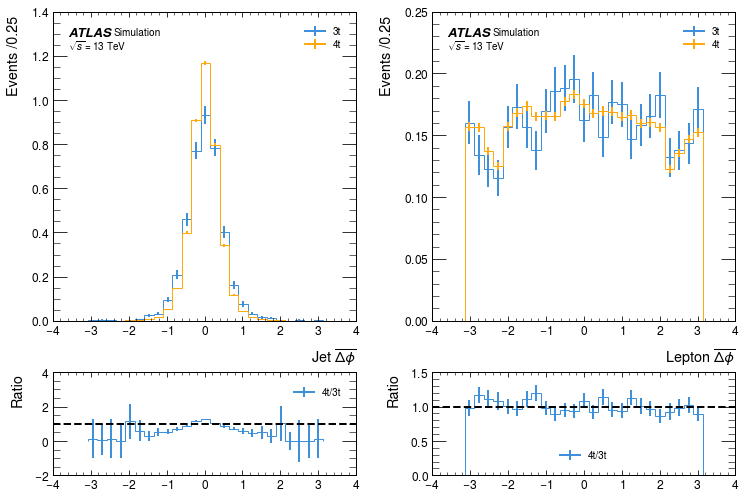

In [10]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltaphi_3t,jet_deltaphi_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\overline{\Delta\phi}$')
histogram([lepton_deltaphi_3t, lepton_deltaphi_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $\overline{\Delta\phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

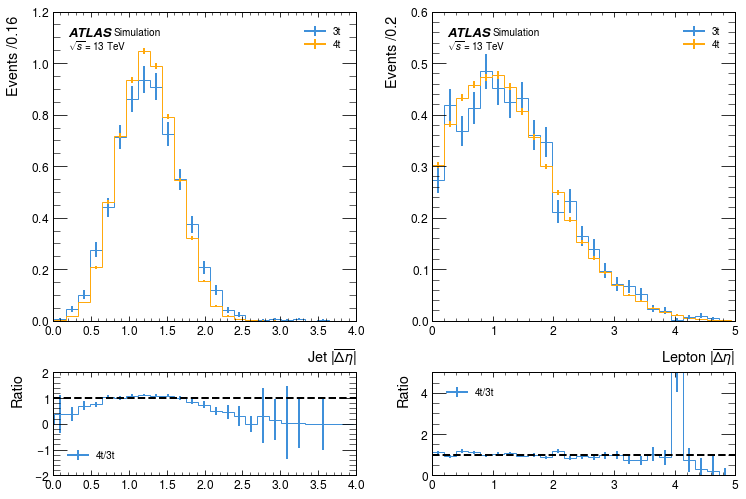

In [11]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltaeta_3t,jet_deltaeta_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $|\overline{\Delta\eta}|$')
histogram([lepton_deltaeta_3t, lepton_deltaeta_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

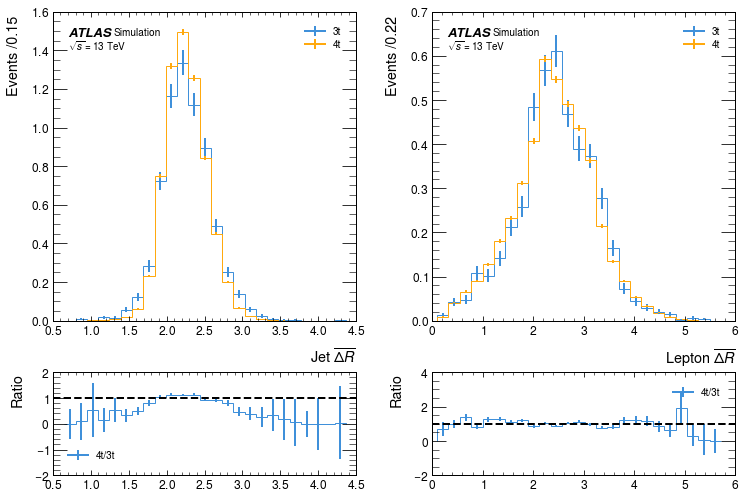

In [12]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltaR_3t,jet_deltaR_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\overline{\Delta R}$')
histogram([lepton_deltaR_3t, lepton_deltaR_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

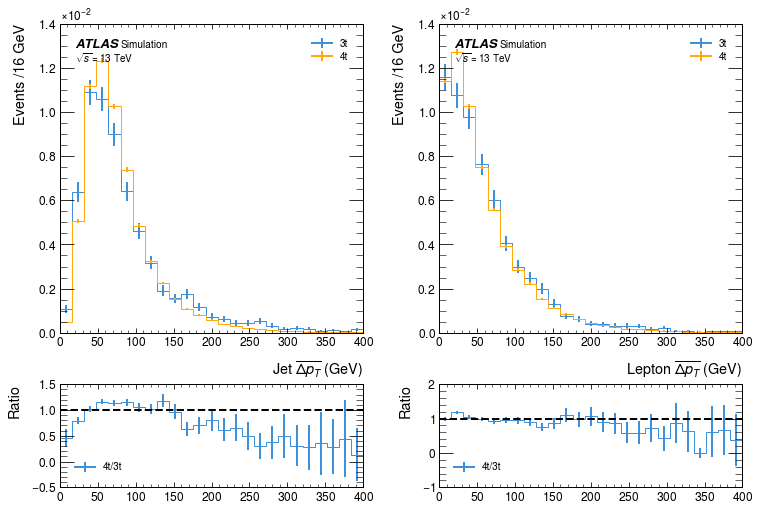

In [13]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltapt_3t/1000, jet_deltapt_4t/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,400))
ax[0,0].set_xlabel(r'Jet $\overline{\Delta p_T}$ (GeV)')
histogram([lepton_deltapt_3t/1000, lepton_deltapt_4t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'Lepton $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

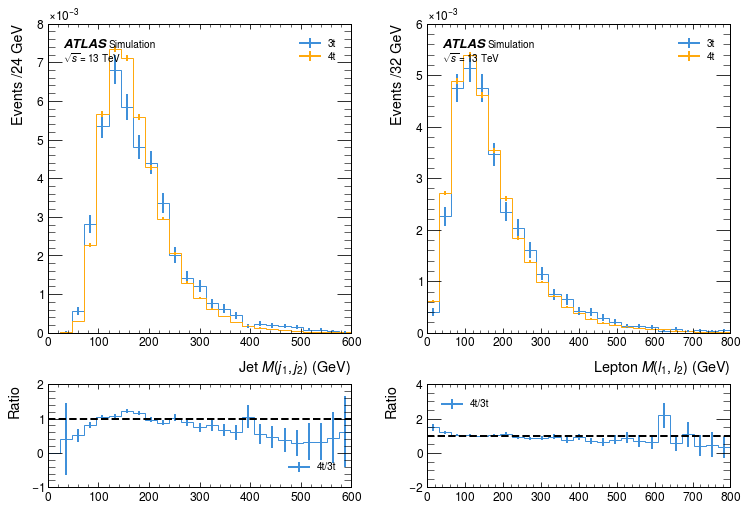

In [14]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_duo_masses_3t/1000, jet_duo_masses_4t/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2)}$ (GeV)')
histogram([lepton_duo_masses_3t/1000, lepton_duo_masses_4t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Lepton ${M(l_1,l_2)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

In [1]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_trio_masses_3t/1000, jet_trio_masses_4t/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1000))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3)}$ (GeV)')
histogram([lepton_trio_masses_3t/1000, lepton_trio_masses_4t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,1000))
ax[0,1].set_xlabel(r'Lepton ${M(l_1,l_2, l_3)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

NameError: name 'plt' is not defined

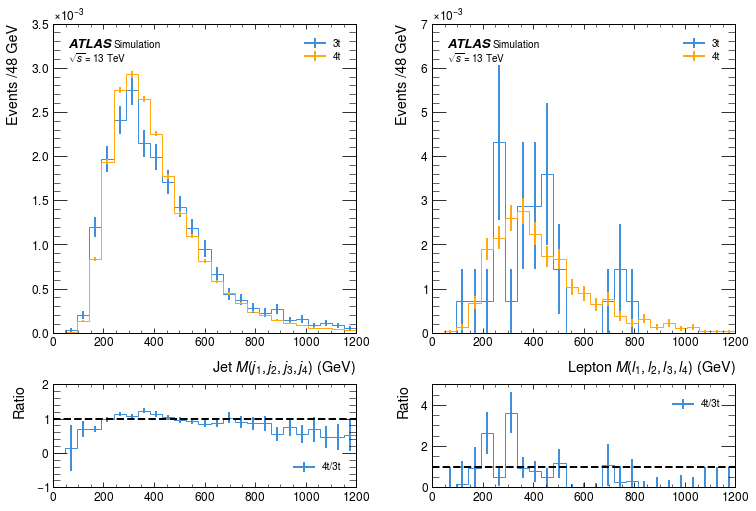

In [16]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_quad_masses_3t/1000, jet_quad_masses_4t/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1200))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4)}$ (GeV)')
histogram([lepton_quad_masses_3t/1000, lepton_quad_masses_4t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,1200))
ax[0,1].set_xlabel(r'Lepton ${M(l_1,l_2, l_3, l_4)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

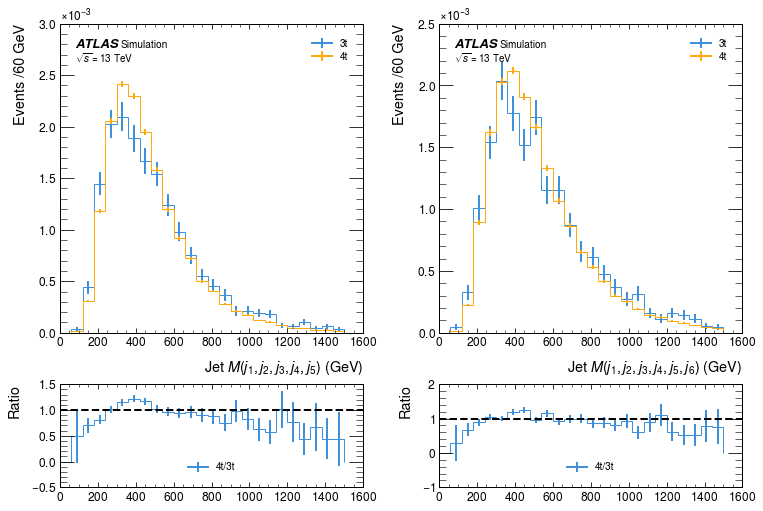

In [17]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_5_masses_3t/1000, jet_5_masses_4t/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1500))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4, j_5)}$ (GeV)')
histogram([jet_6_masses_3t/1000, jet_6_masses_4t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,1500))
ax[0,1].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4, j_5, j_6)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### Total $p_T$ for all particles

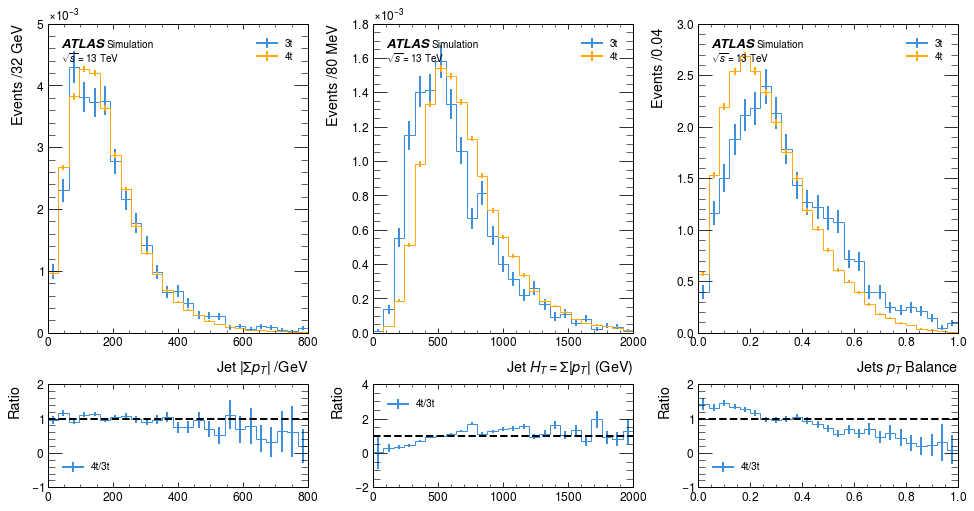

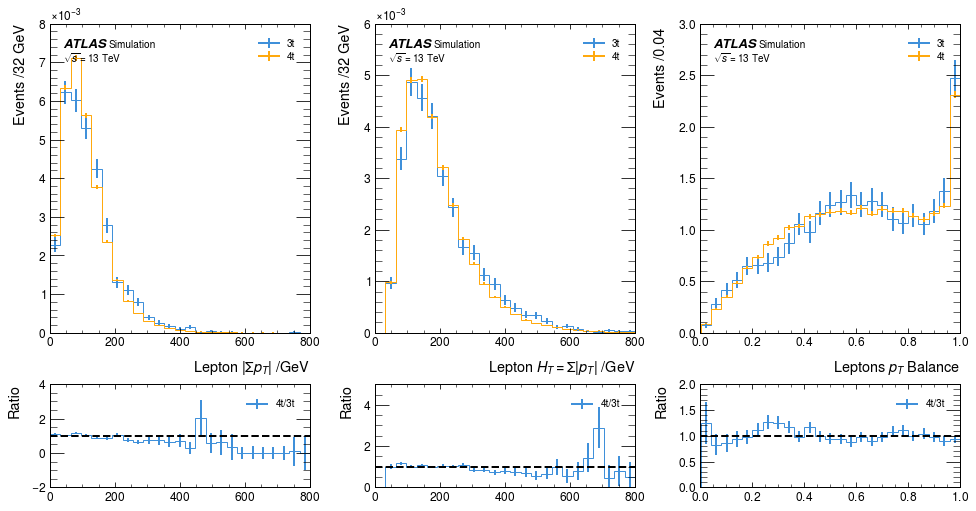

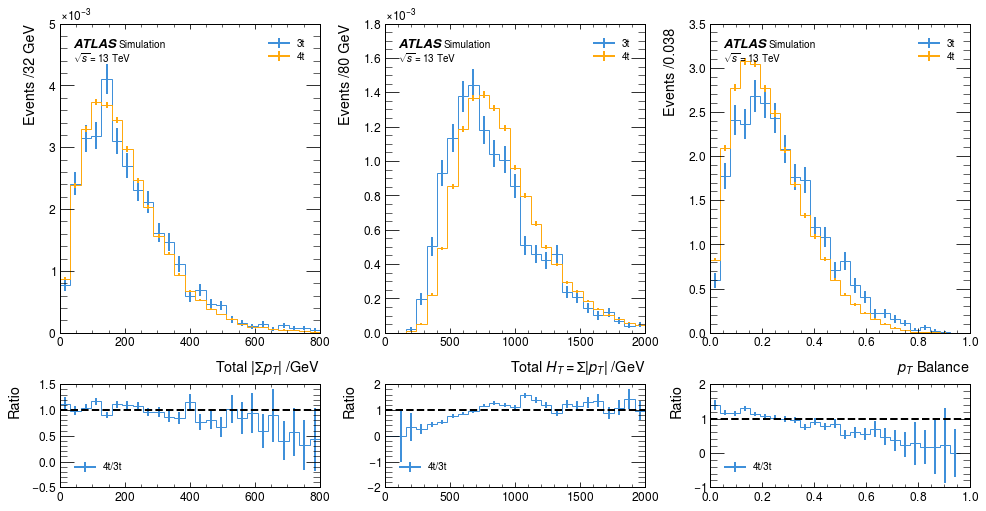

In [18]:
jets_4t_total_4 = np.sum(jets_4t, axis=1)
jets_4t_H_t = np.sum(jets_4t.pt, axis=1)
jets_pt_balance_4t = jets_4t_total_4.pt/jets_4t_H_t

leptons_4t_total_4 = np.sum(leptons_4t, axis=1)
leptons_4t_H_t = np.sum(leptons_4t.pt, axis=1)
leptons_pt_balance_4t = leptons_4t_total_4.pt/leptons_4t_H_t

jets_3t_total_4 = np.sum(jets_3t, axis=1)
jets_3t_H_t = np.sum(jets_3t.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

leptons_3t_total_4 = np.sum(leptons_3t, axis=1)
leptons_3t_H_t = np.sum(leptons_3t.pt, axis=1)
leptons_pt_balance_3t = leptons_3t_total_4.pt/leptons_3t_H_t

total_4_3t = np.sum(all_products_3t, axis=1)
H_t_3t = np.sum(all_products_3t.pt, axis=1)
pt_balance_3t = total_4_3t.pt/H_t_3t

total_4_4t = np.sum(all_products_4t, axis=1)
H_t_4t = np.sum(all_products_4t.pt, axis=1)
pt_balance_4t = total_4_4t.pt/H_t_4t

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([jets_3t_total_4.pt/1000, jets_4t_total_4.pt/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Jet $|\Sigma p_T|$ /GeV')
histogram([jets_3t_H_t/1000, jets_4t_H_t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='MeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Jet $H_T = \Sigma|p_T|$ (GeV)')
histogram([jets_pt_balance_3t, jets_pt_balance_4t], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'Jets $p_T$ Balance')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([leptons_3t_total_4.pt/1000, leptons_4t_total_4.pt/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Lepton $|\Sigma p_T|$ /GeV')
histogram([leptons_3t_H_t/1000, leptons_4t_H_t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Lepton $H_T = \Sigma|p_T|$ /GeV')
histogram([leptons_pt_balance_3t, leptons_pt_balance_4t], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'Leptons $p_T$ Balance')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([total_4_3t.pt/1000, total_4_4t.pt/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Total $|\Sigma p_T|$ /GeV')
histogram([H_t_3t/1000, H_t_4t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Total $H_T = \Sigma|p_T|$ /GeV')
histogram([pt_balance_3t, pt_balance_4t], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'$p_T$ Balance')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### Total $p_T$ for 3 Leading Jets

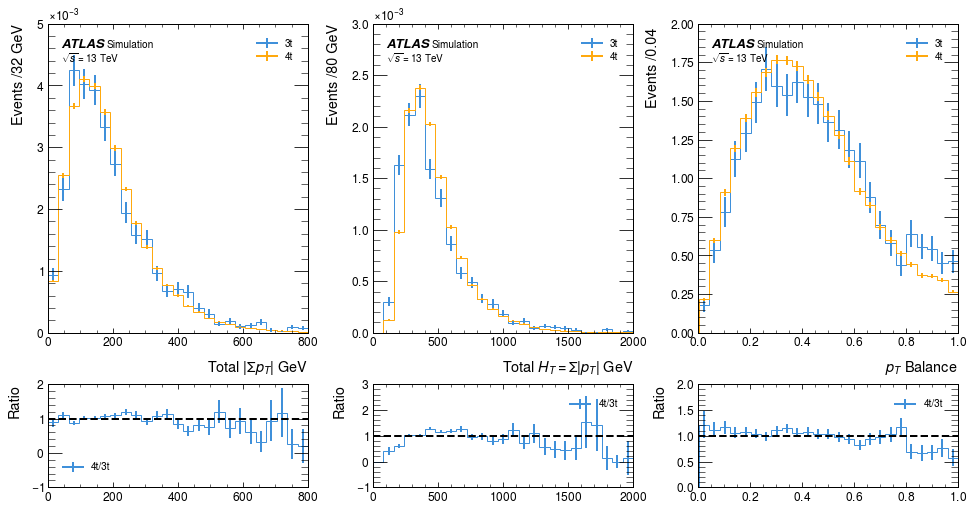

In [19]:
leading_jets_4t_H_t = np.sum(leading_jets_4t.rho, axis=0)
leading_jets_pt_balance_4t = leading_jets_4t_total.pt/leading_jets_4t_H_t

leading_jets_3t_H_t = np.sum(leading_jets_3t.rho, axis=0)
leading_jets_pt_balance_3t = leading_jets_3t_total.pt/leading_jets_3t_H_t

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([leading_jets_3t_total.pt/1000, leading_jets_4t_total.pt/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Total $|\Sigma p_T|$ GeV')
histogram([leading_jets_3t_H_t/1000, leading_jets_4t_H_t/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Total $H_T = \Sigma|p_T|$ GeV')
histogram([leading_jets_pt_balance_3t, leading_jets_pt_balance_4t], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'$p_T$ Balance')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### Total $p_T$ for 2LSS and 3L cases

In [21]:
leptons_2LSS_4t = leptons_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]
jets_2LSS_4t = jets_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]

leptons_3L_4t = leptons_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]
jets_3L_4t = jets_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]

ratio_2LSS_4t = len(leptons_2LSS_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))
ratio_3L_4t = len(leptons_3L_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))

leptons_2LSS_3t = leptons_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]
jets_2LSS_3t = jets_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]

leptons_3L_3t = leptons_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]
jets_3L_3t = jets_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]

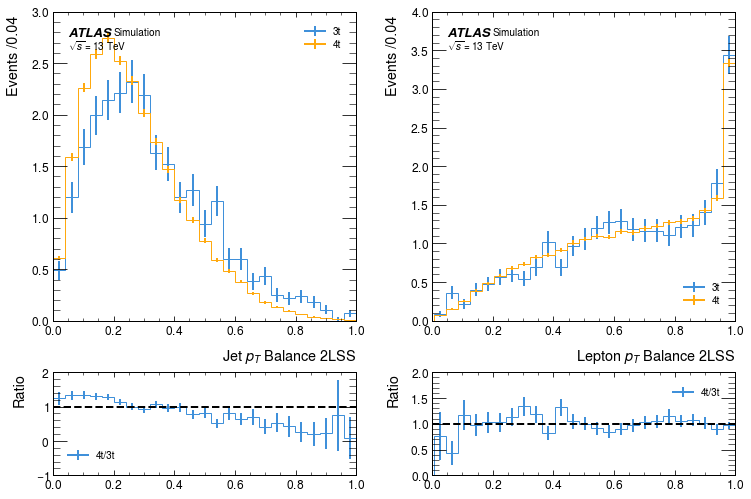

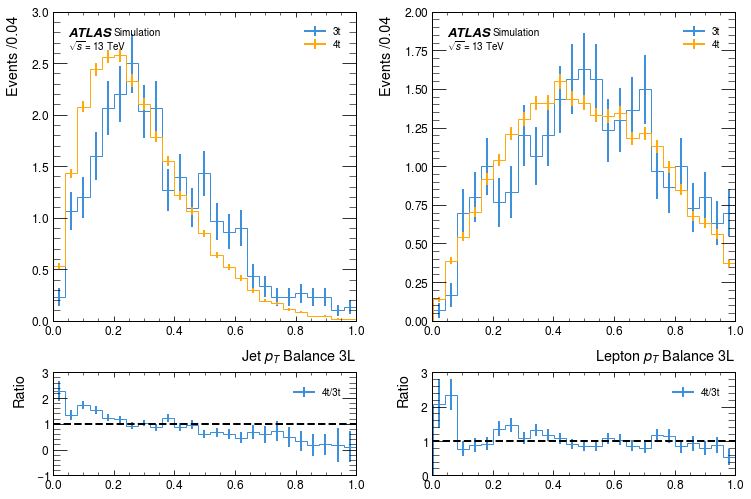

In [22]:
jets_pt_balance_4t_2LSS = np.sum(jets_2LSS_4t, axis=1).pt/np.sum(jets_2LSS_4t.pt, axis=1)
jets_pt_balance_3t_2LSS = np.sum(jets_2LSS_3t, axis=1).pt/np.sum(jets_2LSS_3t.pt, axis=1)

jets_pt_balance_4t_3L = np.sum(jets_3L_4t, axis=1).pt/np.sum(jets_3L_4t.pt, axis=1)
jets_pt_balance_3t_3L = np.sum(jets_3L_3t, axis=1).pt/np.sum(jets_3L_3t.pt, axis=1)

leptons_pt_balance_4t_2LSS = np.sum(leptons_2LSS_4t, axis=1).pt/np.sum(leptons_2LSS_4t.pt, axis=1)
leptons_pt_balance_3t_2LSS = np.sum(leptons_2LSS_3t, axis=1).pt/np.sum(leptons_2LSS_3t.pt, axis=1)

leptons_pt_balance_4t_3L = np.sum(leptons_3L_4t, axis=1).pt/np.sum(leptons_3L_4t.pt, axis=1)
leptons_pt_balance_3t_3L = np.sum(leptons_3L_3t, axis=1).pt/np.sum(leptons_3L_3t.pt, axis=1)

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_pt_balance_3t_2LSS, jets_pt_balance_4t_2LSS], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $p_T$ Balance 2LSS')
histogram([leptons_pt_balance_3t_2LSS, leptons_pt_balance_4t_2LSS], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $p_T$ Balance 2LSS')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_pt_balance_3t_3L, jets_pt_balance_4t_3L], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $p_T$ Balance 3L')
histogram([leptons_pt_balance_3t_3L, leptons_pt_balance_4t_3L], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $p_T$ Balance 3L')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### Total Invariant Mass Plots

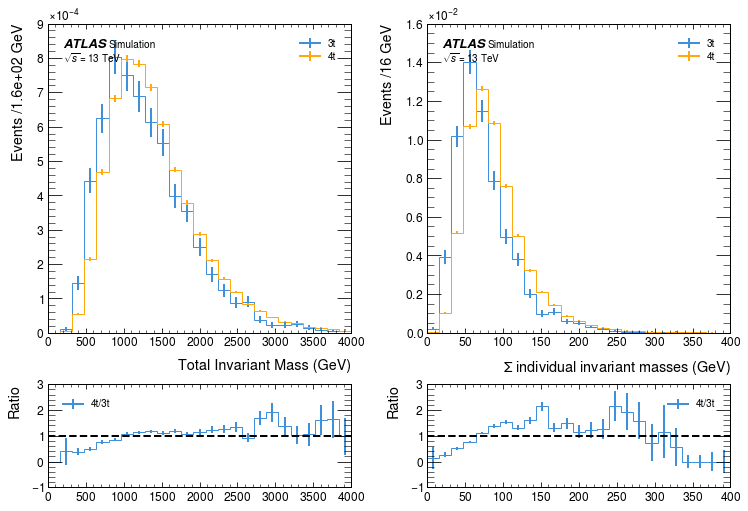

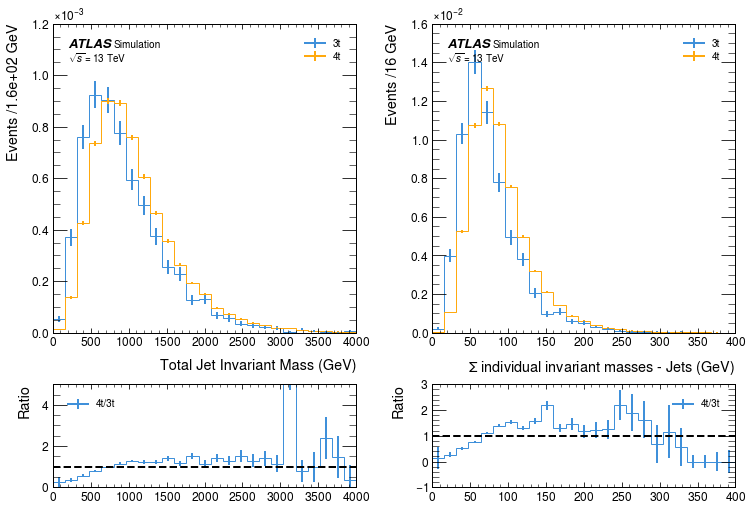

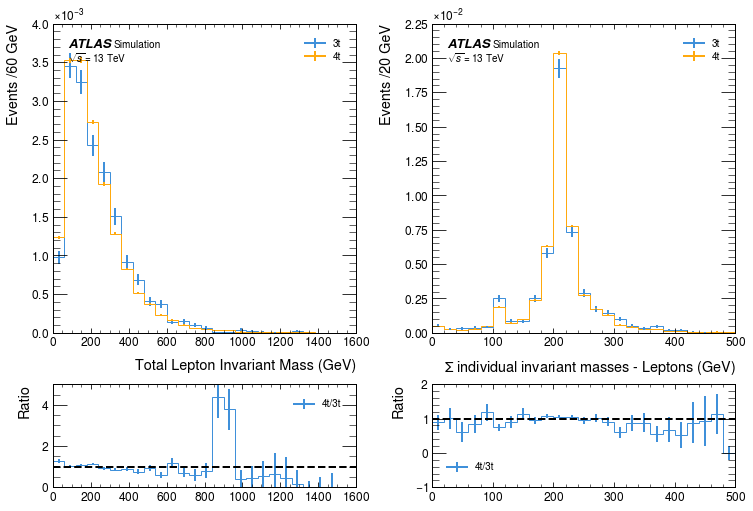

In [23]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([total_4_3t.m/1000, total_4_4t.m/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,4000))
ax[0,0].set_xlabel(r'Total Invariant Mass (GeV)')
histogram([np.sum(all_products_3t.m, axis=1)/1000, np.sum(all_products_4t.m, axis=1)/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_3t_total_4.m/1000, jets_4t_total_4.m/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,4000))
ax[0,0].set_xlabel(r'Total Jet Invariant Mass (GeV)')
histogram([np.sum(jets_3t.m, axis=1)/1000, np.sum(jets_4t.m, axis=1)/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses - Jets (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([leptons_3t_total_4.m/1000, leptons_4t_total_4.m/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1500))
ax[0,0].set_xlabel(r'Total Lepton Invariant Mass (GeV)')
histogram([np.sum(leptons_3t.m, axis=1), np.sum(leptons_4t.m, axis=1)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,500))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses - Leptons (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### N(B)

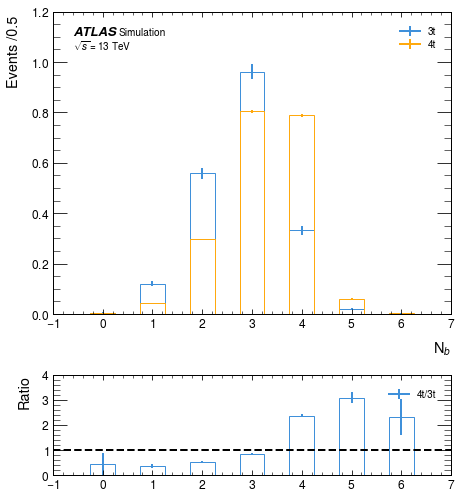

In [24]:
N_B_3t = awkward.num(events_3t['jet_partonid'][events_3t['jet_partonid']==5])
N_B_4t = awkward.num(events_4t['jet_partonid'][events_4t['jet_partonid']==5])
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(7,8))
histogram([N_B_3t, N_B_4t], 14, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='', set_range=(-0.25,6.75))
ax[0].set_xlabel(r'N$_b$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

### Centrality and Sphericity

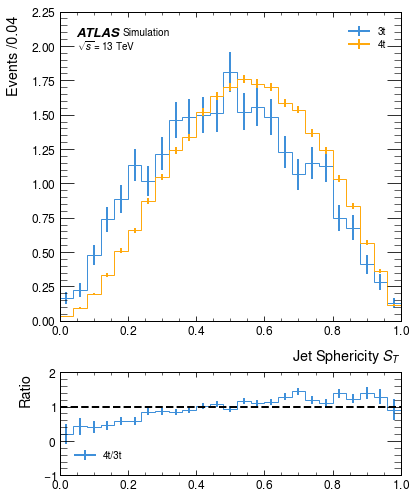

In [25]:
sum_pt_jets_3t = np.sum(jets_3t.pt, axis=1)

S_xy_jets_3t = np.zeros((len(jets_3t),2,2))


S_xy_jets_3t[:,0,0] = np.sum(jets_3t.px**2/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((jets_3t.px*jets_3t.py)/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(jets_3t.py**2/ jets_3t.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(jets_4t.pt, axis=1)

S_xy_jets_4t = np.zeros((len(jets_4t),2,2))


S_xy_jets_4t[:,0,0] = np.sum(jets_4t.px**2/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((jets_4t.px*jets_4t.py)/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(jets_4t.py**2/ jets_4t.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_jets_3t, sphericity_jets_4t], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Jet Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

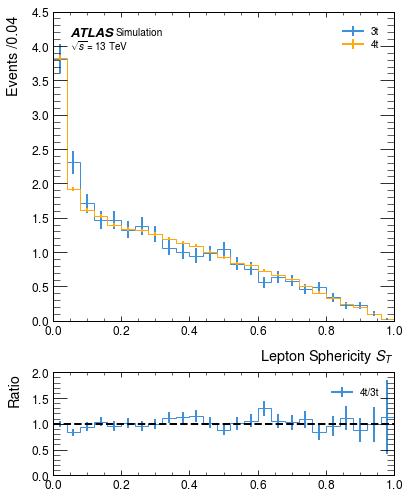

In [26]:
sum_pt_leptons_3t = np.sum(leptons_3t.pt, axis=1)

S_xy_leptons_3t = np.zeros((len(leptons_3t),2,2))


S_xy_leptons_3t[:,0,0] = np.sum(leptons_3t.px**2/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,0,1] = np.sum((leptons_3t.px*leptons_3t.py)/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,1,0] = S_xy_leptons_3t[:,0,1]
S_xy_leptons_3t[:,1,1] = np.sum(leptons_3t.py**2/ leptons_3t.pt, axis=1)


S_xy_leptons_3t = S_xy_leptons_3t/sum_pt_leptons_3t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_3t = np.linalg.eigvalsh(S_xy_leptons_3t)

sphericity_leptons_3t = 2*np.min(eigenvalues_leptons_3t, axis=1)/np.sum(eigenvalues_leptons_3t, axis=1)

sum_pt_leptons_4t = np.sum(leptons_4t.pt, axis=1)

S_xy_leptons_4t = np.zeros((len(leptons_4t),2,2))


S_xy_leptons_4t[:,0,0] = np.sum(leptons_4t.px**2/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,0,1] = np.sum((leptons_4t.px*leptons_4t.py)/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,1,0] = S_xy_leptons_4t[:,0,1]
S_xy_leptons_4t[:,1,1] = np.sum(leptons_4t.py**2/ leptons_4t.pt, axis=1)


S_xy_leptons_4t = S_xy_leptons_4t/sum_pt_leptons_4t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_4t = np.linalg.eigvalsh(S_xy_leptons_4t)

sphericity_leptons_4t = 2*np.min(eigenvalues_leptons_4t, axis=1)/np.sum(eigenvalues_leptons_4t, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_leptons_3t, sphericity_leptons_4t], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Lepton Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

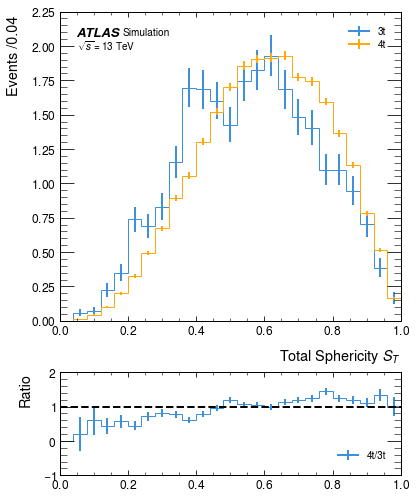

In [27]:
sum_pt_all_3t = np.sum(all_products_3t.pt, axis=1)

S_all_3t = np.zeros((len(all_products_3t),2,2))


S_all_3t[:,0,0] = np.sum(all_products_3t.px**2/ all_products_3t.pt, axis=1)
S_all_3t[:,0,1] = np.sum((all_products_3t.px*all_products_3t.py)/ all_products_3t.pt, axis=1)
S_all_3t[:,1,0] = S_all_3t[:,0,1]
S_all_3t[:,1,1] = np.sum(all_products_3t.py**2/ all_products_3t.pt, axis=1)


S_all_3t = S_all_3t/sum_pt_all_3t[:,np.newaxis,np.newaxis]

eigenvalues_all_3t = np.linalg.eigvalsh(S_all_3t)

sphericity_all_3t = 2*np.min(eigenvalues_all_3t, axis=1)/np.sum(eigenvalues_all_3t, axis=1)

sum_pt_all_4t = np.sum(all_products_4t.pt, axis=1)

S_all_4t = np.zeros((len(all_products_4t),2,2))


S_all_4t[:,0,0] = np.sum(all_products_4t.px**2/ all_products_4t.pt, axis=1)
S_all_4t[:,0,1] = np.sum((all_products_4t.px*all_products_4t.py)/ all_products_4t.pt, axis=1)
S_all_4t[:,1,0] = S_all_4t[:,0,1]
S_all_4t[:,1,1] = np.sum(all_products_4t.py**2/ all_products_4t.pt, axis=1)


S_all_4t = S_all_4t/sum_pt_all_4t[:,np.newaxis,np.newaxis]

eigenvalues_all_4t = np.linalg.eigvalsh(S_all_4t)

sphericity_all_4t = 2*np.min(eigenvalues_all_4t, axis=1)/np.sum(eigenvalues_all_4t, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_all_3t, sphericity_all_4t], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Total Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

## Sorting

In [2]:
#pt
highest_pt_jet_4t = jets_4t[:,0]
highest_pt_jet_3t = jets_3t[:,0]
highest_pt_lepton_4t = leptons_4t[:,0]
highest_pt_lepton_3t = leptons_3t[:,0]

lowest_pt_jet_4t = jets_4t[:,-1]
lowest_pt_jet_3t = jets_3t[:,-1]
lowest_pt_lepton_4t = leptons_4t[:,-1]
lowest_pt_lepton_3t = leptons_3t[:,-1]

second_highest_pt_jet_4t = jets_4t[:,1]
second_highest_pt_jet_3t = jets_3t[:,1]
second_highest_pt_lepton_4t = leptons_4t[:,1]
second_highest_pt_lepton_3t = leptons_3t[:,1]

second_lowest_pt_jet_4t = jets_4t[:,-2]
second_lowest_pt_jet_3t = jets_3t[:,-2]
second_lowest_pt_lepton_4t = leptons_4t[:,-2]
second_lowest_pt_lepton_3t = leptons_3t[:,-2]

#total
highest_pt_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_pt_jet_3t]), awkward.Array([second_highest_pt_jet_3t]), awkward.Array([highest_pt_lepton_3t]), awkward.Array([second_highest_pt_lepton_3t])], axis=0))
sorted_highest_pt_finder_3t = highest_pt_finder_3t[np.argsort(highest_pt_finder_3t.rho, axis=1)]

highest_pt_3t = vector.zip({'pt':sorted_highest_pt_finder_3t.rho[:,-1],'eta':sorted_highest_pt_finder_3t.eta[:,-1],'phi':sorted_highest_pt_finder_3t.phi[:,-1], 'energy':sorted_highest_pt_finder_3t.t[:,-1]})
second_highest_pt_3t = vector.zip({'pt':sorted_highest_pt_finder_3t.rho[:,-2],'eta':sorted_highest_pt_finder_3t.eta[:,-2],'phi':sorted_highest_pt_finder_3t.phi[:,-2], 'energy':sorted_highest_pt_finder_3t.t[:,-2]})

lowest_pt_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_pt_jet_3t]), awkward.Array([second_lowest_pt_jet_3t]), awkward.Array([lowest_pt_lepton_3t]), awkward.Array([second_lowest_pt_lepton_3t])], axis=0))
sorted_lowest_pt_finder_3t = lowest_pt_finder_3t[np.argsort(lowest_pt_finder_3t.rho, axis=1)]

second_lowest_pt_3t = vector.zip({'pt':sorted_lowest_pt_finder_3t.rho[:,1],'eta':sorted_lowest_pt_finder_3t.eta[:,1],'phi':sorted_lowest_pt_finder_3t.phi[:,1], 'energy':sorted_lowest_pt_finder_3t.t[:,1]})
lowest_pt_3t = vector.zip({'pt':sorted_lowest_pt_finder_3t.rho[:,0],'eta':sorted_lowest_pt_finder_3t.eta[:,0],'phi':sorted_lowest_pt_finder_3t.phi[:,0], 'energy':sorted_lowest_pt_finder_3t.t[:,0]})

highest_pt_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_pt_jet_4t]), awkward.Array([second_highest_pt_jet_4t]), awkward.Array([highest_pt_lepton_4t]), awkward.Array([second_highest_pt_lepton_4t])], axis=0))
sorted_highest_pt_finder_4t = highest_pt_finder_4t[np.argsort(highest_pt_finder_4t.rho,axis=1)]

highest_pt_4t = vector.zip({'pt':sorted_highest_pt_finder_4t.rho[:,-1],'eta':sorted_highest_pt_finder_4t.eta[:,-1],'phi':sorted_highest_pt_finder_4t.phi[:,-1], 'energy':sorted_highest_pt_finder_4t.t[:,-1]})
second_highest_pt_4t = vector.zip({'pt':sorted_highest_pt_finder_4t.rho[:,-2],'eta':sorted_highest_pt_finder_4t.eta[:,-2],'phi':sorted_highest_pt_finder_4t.phi[:,-2], 'energy':sorted_highest_pt_finder_4t.t[:,-2]})

lowest_pt_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_pt_jet_4t]), awkward.Array([second_lowest_pt_jet_4t]), awkward.Array([lowest_pt_lepton_4t]), awkward.Array([second_lowest_pt_lepton_4t])], axis=0))
sorted_lowest_pt_finder_4t = lowest_pt_finder_4t[np.argsort(lowest_pt_finder_4t.rho,axis=1)]

second_lowest_pt_4t = vector.zip({'pt':sorted_lowest_pt_finder_4t.rho[:,1],'eta':sorted_lowest_pt_finder_4t.eta[:,1],'phi':sorted_lowest_pt_finder_4t.phi[:,1], 'energy':sorted_lowest_pt_finder_4t.t[:,1]})
lowest_pt_4t = vector.zip({'pt':sorted_lowest_pt_finder_4t.rho[:,0],'eta':sorted_lowest_pt_finder_4t.eta[:,0],'phi':sorted_lowest_pt_finder_4t.phi[:,0], 'energy':sorted_lowest_pt_finder_4t.t[:,0]})

#eta
eta_4t_jets = jets_4t[np.argsort(np.abs(jets_4t.eta))]
eta_3t_jets = jets_3t[np.argsort(np.abs(jets_3t.eta))]
eta_4t_leptons = leptons_4t[np.argsort(np.abs(leptons_4t.eta))]
eta_3t_leptons = leptons_3t[np.argsort(np.abs(leptons_3t.eta))]

highest_eta_jet_4t = eta_4t_jets[:,-1]
highest_eta_jet_3t = eta_3t_jets[:,-1]
highest_eta_lepton_4t = eta_4t_leptons[:,-1]
highest_eta_lepton_3t = eta_3t_leptons[:,-1]

second_highest_eta_jet_4t = eta_4t_jets[:,-2]
second_highest_eta_jet_3t = eta_3t_jets[:,-2]
second_highest_eta_lepton_4t = eta_4t_leptons[:,-2]
second_highest_eta_lepton_3t = eta_3t_leptons[:,-2]

lowest_eta_jet_4t = eta_4t_jets[:,0]
lowest_eta_jet_3t = eta_3t_jets[:,0]
lowest_eta_lepton_4t = eta_4t_leptons[:,0]
lowest_eta_lepton_3t = eta_3t_leptons[:,0]

second_lowest_eta_jet_4t = eta_4t_jets[:,1]
second_lowest_eta_jet_3t = eta_3t_jets[:,1]
second_lowest_eta_lepton_4t = eta_4t_leptons[:,1]
second_lowest_eta_lepton_3t = eta_3t_leptons[:,1]

#total
highest_eta_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_eta_jet_3t]), awkward.Array([second_highest_eta_jet_3t]), awkward.Array([highest_eta_lepton_3t]), awkward.Array([second_highest_eta_lepton_3t])], axis=0))
sorted_highest_eta_finder_3t = highest_eta_finder_3t[np.argsort(highest_eta_finder_3t.eta,axis=1)]

highest_eta_3t = vector.zip({'pt':sorted_highest_eta_finder_3t.rho[:,-1],'eta':sorted_highest_eta_finder_3t.eta[:,-1],'phi':sorted_highest_eta_finder_3t.phi[:,-1], 'energy':sorted_highest_eta_finder_3t.t[:,-1]})
second_highest_eta_3t = vector.zip({'pt':sorted_highest_eta_finder_3t.rho[:,-2],'eta':sorted_highest_eta_finder_3t.eta[:,-2],'phi':sorted_highest_eta_finder_3t.phi[:,-2], 'energy':sorted_highest_eta_finder_3t.t[:,-2]})

lowest_eta_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_eta_jet_3t]), awkward.Array([second_lowest_eta_jet_3t]), awkward.Array([lowest_eta_lepton_3t]), awkward.Array([second_lowest_eta_lepton_3t])], axis=0))
sorted_lowest_eta_finder_3t = lowest_eta_finder_3t[np.argsort(lowest_eta_finder_3t.eta,axis=1)]

second_lowest_eta_3t = vector.zip({'pt':sorted_lowest_eta_finder_3t.rho[:,1],'eta':sorted_lowest_eta_finder_3t.eta[:,1],'phi':sorted_lowest_eta_finder_3t.phi[:,1], 'energy':sorted_lowest_eta_finder_3t.t[:,1]})
lowest_eta_3t = vector.zip({'pt':sorted_lowest_eta_finder_3t.rho[:,0],'eta':sorted_lowest_eta_finder_3t.eta[:,0],'phi':sorted_lowest_eta_finder_3t.phi[:,0], 'energy':sorted_lowest_eta_finder_3t.t[:,0]})

highest_eta_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_eta_jet_4t]), awkward.Array([second_highest_eta_jet_4t]), awkward.Array([highest_eta_lepton_4t]), awkward.Array([second_highest_eta_lepton_4t])], axis=0))
sorted_highest_eta_finder_4t = highest_eta_finder_4t[np.argsort(highest_eta_finder_4t.eta,axis=1)]

highest_eta_4t = vector.zip({'pt':sorted_highest_eta_finder_4t.rho[:,-1],'eta':sorted_highest_eta_finder_4t.eta[:,-1],'phi':sorted_highest_eta_finder_4t.phi[:,-1], 'energy':sorted_highest_eta_finder_4t.t[:,-1]})
second_highest_eta_4t = vector.zip({'pt':sorted_highest_eta_finder_4t.rho[:,-2],'eta':sorted_highest_eta_finder_4t.eta[:,-2],'phi':sorted_highest_eta_finder_4t.phi[:,-2], 'energy':sorted_highest_eta_finder_4t.t[:,-2]})

lowest_eta_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_eta_jet_4t]), awkward.Array([second_lowest_eta_jet_4t]), awkward.Array([lowest_eta_lepton_4t]), awkward.Array([second_lowest_eta_lepton_4t])], axis=0))
sorted_lowest_eta_finder_4t = lowest_eta_finder_4t[np.argsort(lowest_eta_finder_4t.eta,axis=1)]

second_lowest_eta_4t = vector.zip({'pt':sorted_lowest_eta_finder_4t.rho[:,1],'eta':sorted_lowest_eta_finder_4t.eta[:,1],'phi':sorted_lowest_eta_finder_4t.phi[:,1], 'energy':sorted_lowest_eta_finder_4t.t[:,1]})
lowest_eta_4t = vector.zip({'pt':sorted_lowest_eta_finder_4t.rho[:,0],'eta':sorted_lowest_eta_finder_4t.eta[:,0],'phi':sorted_lowest_eta_finder_4t.phi[:,0], 'energy':sorted_lowest_eta_finder_4t.t[:,0]})

#phi
phi_4t_jets = jets_4t[np.argsort(jets_4t.phi)]
phi_3t_jets = jets_3t[np.argsort(jets_3t.phi)]
phi_4t_leptons = leptons_4t[np.argsort(leptons_4t.phi)]
phi_3t_leptons = leptons_3t[np.argsort(leptons_3t.phi)]

highest_phi_jet_4t = phi_4t_jets[:,-1]
highest_phi_jet_3t = phi_3t_jets[:,-1]
highest_phi_lepton_4t = phi_4t_leptons[:,-1]
highest_phi_lepton_3t = phi_3t_leptons[:,-1]

second_highest_phi_jet_4t = phi_4t_jets[:,-2]
second_highest_phi_jet_3t = phi_3t_jets[:,-2]
second_highest_phi_lepton_4t = phi_4t_leptons[:,-2]
second_highest_phi_lepton_3t = phi_3t_leptons[:,-2]

lowest_phi_jet_4t = phi_4t_jets[:,0]
lowest_phi_jet_3t = phi_3t_jets[:,0]
lowest_phi_lepton_4t = phi_4t_leptons[:,0]
lowest_phi_lepton_3t = phi_3t_leptons[:,0]

second_lowest_phi_jet_4t = phi_4t_jets[:,1]
second_lowest_phi_jet_3t = phi_3t_jets[:,1]
second_lowest_phi_lepton_4t = phi_4t_leptons[:,1]
second_lowest_phi_lepton_3t = phi_3t_leptons[:,1]

#total
highest_phi_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_phi_jet_3t]), awkward.Array([second_highest_phi_jet_3t]), awkward.Array([highest_phi_lepton_3t]), awkward.Array([second_highest_phi_lepton_3t])], axis=0))
sorted_highest_phi_finder_3t = highest_phi_finder_3t[np.argsort(highest_phi_finder_3t.phi,axis=1)]

highest_phi_3t = vector.zip({'pt':sorted_highest_phi_finder_3t.rho[:,-1],'eta':sorted_highest_phi_finder_3t.eta[:,-1],'phi':sorted_highest_phi_finder_3t.phi[:,-1], 'energy':sorted_highest_phi_finder_3t.t[:,-1]})
second_highest_phi_3t = vector.zip({'pt':sorted_highest_phi_finder_3t.rho[:,-2],'eta':sorted_highest_phi_finder_3t.eta[:,-2],'phi':sorted_highest_phi_finder_3t.phi[:,-2], 'energy':sorted_highest_phi_finder_3t.t[:,-2]})

lowest_phi_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_phi_jet_3t]), awkward.Array([second_lowest_phi_jet_3t]), awkward.Array([lowest_phi_lepton_3t]), awkward.Array([second_lowest_phi_lepton_3t])], axis=0))
sorted_lowest_phi_finder_3t = lowest_phi_finder_3t[np.argsort(lowest_phi_finder_3t.phi,axis=1)]

second_lowest_phi_3t = vector.zip({'pt':sorted_lowest_phi_finder_3t.rho[:,1],'eta':sorted_lowest_phi_finder_3t.eta[:,1],'phi':sorted_lowest_phi_finder_3t.phi[:,1], 'energy':sorted_lowest_phi_finder_3t.t[:,1]})
lowest_phi_3t = vector.zip({'pt':sorted_lowest_phi_finder_3t.rho[:,0],'eta':sorted_lowest_phi_finder_3t.eta[:,0],'phi':sorted_lowest_phi_finder_3t.phi[:,0], 'energy':sorted_lowest_phi_finder_3t.t[:,0]})

highest_phi_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_phi_jet_4t]), awkward.Array([second_highest_phi_jet_4t]), awkward.Array([highest_phi_lepton_4t]), awkward.Array([second_highest_phi_lepton_4t])], axis=0))
sorted_highest_phi_finder_4t = highest_phi_finder_4t[np.argsort(highest_phi_finder_4t.phi,axis=1)]

highest_phi_4t = vector.zip({'pt':sorted_highest_phi_finder_4t.rho[:,-1],'eta':sorted_highest_phi_finder_4t.eta[:,-1],'phi':sorted_highest_phi_finder_4t.phi[:,-1], 'energy':sorted_highest_phi_finder_4t.t[:,-1]})
second_highest_phi_4t = vector.zip({'pt':sorted_highest_phi_finder_4t.rho[:,-2],'eta':sorted_highest_phi_finder_4t.eta[:,-2],'phi':sorted_highest_phi_finder_4t.phi[:,-2], 'energy':sorted_highest_phi_finder_4t.t[:,-2]})

lowest_phi_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_phi_jet_4t]), awkward.Array([second_lowest_phi_jet_4t]), awkward.Array([lowest_phi_lepton_4t]), awkward.Array([second_lowest_phi_lepton_4t])], axis=0))
sorted_lowest_phi_finder_4t = lowest_phi_finder_4t[np.argsort(lowest_phi_finder_4t.phi,axis=1)]

second_lowest_phi_4t = vector.zip({'pt':sorted_lowest_phi_finder_4t.rho[:,1],'eta':sorted_lowest_phi_finder_4t.eta[:,1],'phi':sorted_lowest_phi_finder_4t.phi[:,1], 'energy':sorted_lowest_phi_finder_4t.t[:,1]})
lowest_phi_4t = vector.zip({'pt':sorted_lowest_phi_finder_4t.rho[:,0],'eta':sorted_lowest_phi_finder_4t.eta[:,0],'phi':sorted_lowest_phi_finder_4t.phi[:,0], 'energy':sorted_lowest_phi_finder_4t.t[:,0]})

NameError: name 'jets_4t' is not defined

### Calculations

In [204]:
#pt
deltaR_highest_pt_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
deltaR_lowest_pt_4t = lowest_pt_4t.deltaR(second_lowest_pt_4t)

deltaR_highest_pt_3t = highest_pt_3t.deltaR(second_highest_pt_3t)
deltaR_lowest_pt_3t = lowest_pt_3t.deltaR(second_lowest_pt_3t)

deltaphi_highest_pt_4t = np.abs(highest_pt_4t.deltaphi(second_highest_pt_4t))
deltaphi_lowest_pt_4t = np.abs(lowest_pt_4t.deltaphi(second_lowest_pt_4t))
deltaeta_highest_pt_4t = np.abs(highest_pt_4t.deltaeta(second_highest_pt_4t))
deltaeta_lowest_pt_4t = np.abs(lowest_pt_4t.deltaeta(second_lowest_pt_4t))

deltaphi_highest_pt_3t = np.abs(highest_pt_3t.deltaphi(second_highest_pt_3t))
deltaphi_lowest_pt_3t = np.abs(lowest_pt_3t.deltaphi(second_lowest_pt_3t))
deltaeta_highest_pt_3t = np.abs(highest_pt_3t.deltaeta(second_highest_pt_3t))
deltaeta_lowest_pt_3t = np.abs(lowest_pt_3t.deltaeta(second_lowest_pt_3t))

#eta
deltaR_highest_eta_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
deltaR_lowest_eta_4t = lowest_eta_4t.deltaR(second_lowest_eta_4t)

deltaR_highest_eta_3t = highest_eta_3t.deltaR(second_highest_eta_3t)
deltaR_lowest_eta_3t = lowest_eta_3t.deltaR(second_lowest_eta_3t)

deltaphi_highest_eta_4t = np.abs(highest_eta_4t.deltaphi(second_highest_eta_4t))
deltaphi_lowest_eta_4t = np.abs(lowest_eta_4t.deltaphi(second_lowest_eta_4t))
deltaeta_highest_eta_4t = np.abs(highest_eta_4t.deltaeta(second_highest_eta_4t))
deltaeta_lowest_eta_4t = np.abs(lowest_eta_4t.deltaeta(second_lowest_eta_4t))

deltaphi_highest_eta_3t = np.abs(highest_eta_3t.deltaphi(second_highest_eta_3t))
deltaphi_lowest_eta_3t = np.abs(lowest_eta_3t.deltaphi(second_lowest_eta_3t))
deltaeta_highest_eta_3t = np.abs(highest_eta_3t.deltaeta(second_highest_eta_3t))
deltaeta_lowest_eta_3t = np.abs(lowest_eta_3t.deltaeta(second_lowest_eta_3t))

#phi
deltaR_highest_phi_4t = highest_phi_4t.deltaR(second_highest_phi_4t)
deltaR_lowest_phi_4t = lowest_phi_4t.deltaR(second_lowest_phi_4t)

deltaR_highest_phi_3t = highest_phi_3t.deltaR(second_highest_phi_3t)
deltaR_lowest_phi_3t = lowest_phi_3t.deltaR(second_lowest_phi_3t)

deltaphi_highest_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
deltaphi_lowest_phi_4t = np.abs(lowest_phi_4t.deltaphi(second_lowest_phi_4t))
deltaeta_highest_phi_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
deltaeta_lowest_phi_4t = np.abs(lowest_phi_4t.deltaeta(second_lowest_phi_4t))

deltaphi_highest_phi_3t = np.abs(highest_phi_3t.deltaphi(second_highest_phi_3t))
deltaphi_lowest_phi_3t = np.abs(lowest_phi_3t.deltaphi(second_lowest_phi_3t))
deltaeta_highest_phi_3t = np.abs(highest_phi_3t.deltaeta(second_highest_phi_3t))
deltaeta_lowest_phi_3t = np.abs(lowest_phi_3t.deltaeta(second_lowest_phi_3t))


## Plots
### Pt

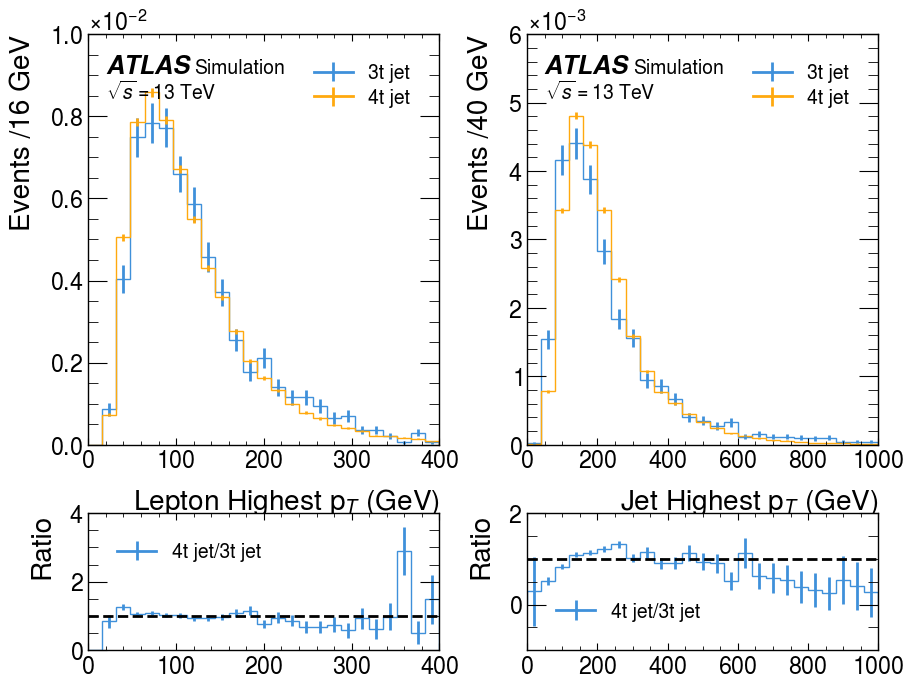

In [205]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
weights = [np.ones_like(highest_pt_lepton_3t.pt)*len(highest_pt_lepton_4t.pt)/(len(highest_pt_lepton_3t.pt)+len(highest_pt_lepton_4t.pt)), np.ones_like(highest_pt_lepton_4t.pt)*len(highest_pt_lepton_3t.pt)/(len(highest_pt_lepton_3t.pt)+len(highest_pt_lepton_4t.pt))]
histogram([highest_pt_lepton_3t.pt/1000, highest_pt_lepton_4t.pt/1000], 25, ['3t jet','4t jet'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
weights = [np.ones_like(highest_pt_jet_3t.pt)*len(highest_pt_jet_4t.pt)/(len(highest_pt_jet_3t.pt)+len(highest_pt_jet_4t.pt)), np.ones_like(highest_pt_jet_4t.pt)*len(highest_pt_jet_3t.pt)/(len(highest_pt_jet_3t.pt)+len(highest_pt_jet_4t.pt))]
histogram([highest_pt_jet_3t.pt/1000, highest_pt_jet_4t.pt/1000], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E3))
ax[0,0].set_xlabel(r'Lepton Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Jet Highest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

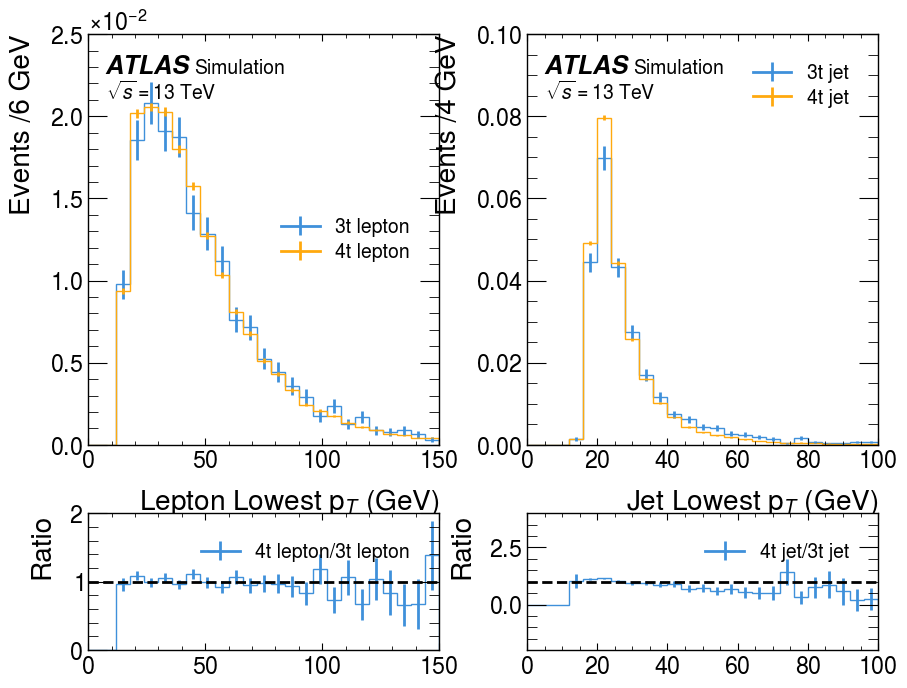

In [206]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_lepton_3t.pt/1000, lowest_pt_lepton_4t.pt/1000], 25, ['3t lepton','4t lepton'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1.5E2))
histogram([lowest_pt_jet_3t.pt/1000, lowest_pt_jet_4t.pt/1000], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Jet Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

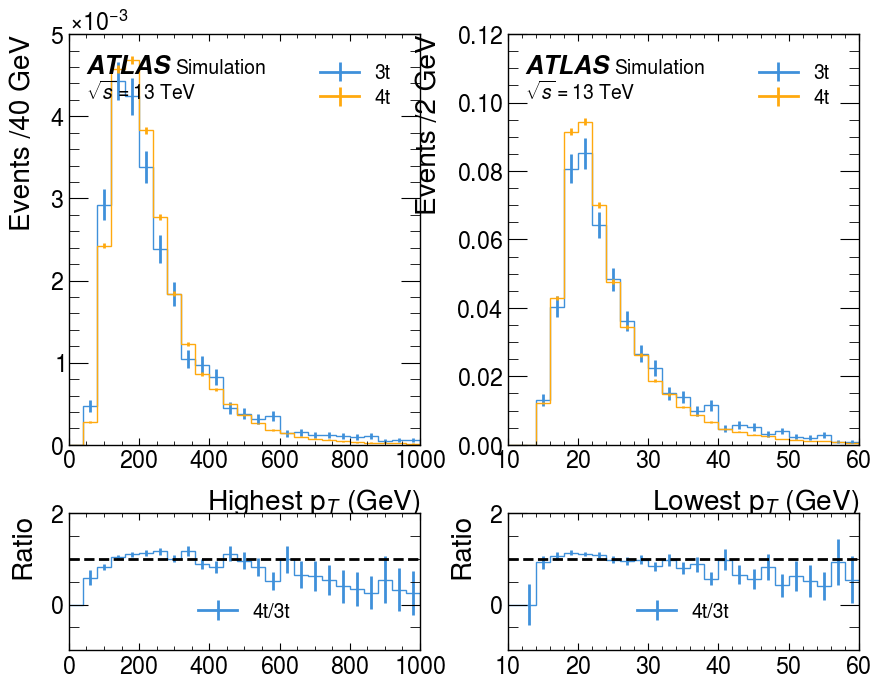

In [207]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_3t.pt/1000, highest_pt_4t.pt/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1E3))
histogram([lowest_pt_3t.pt/1000, lowest_pt_4t.pt/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(10,6E1))
ax[0,0].set_xlabel(r'Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### 2. $|\eta|$

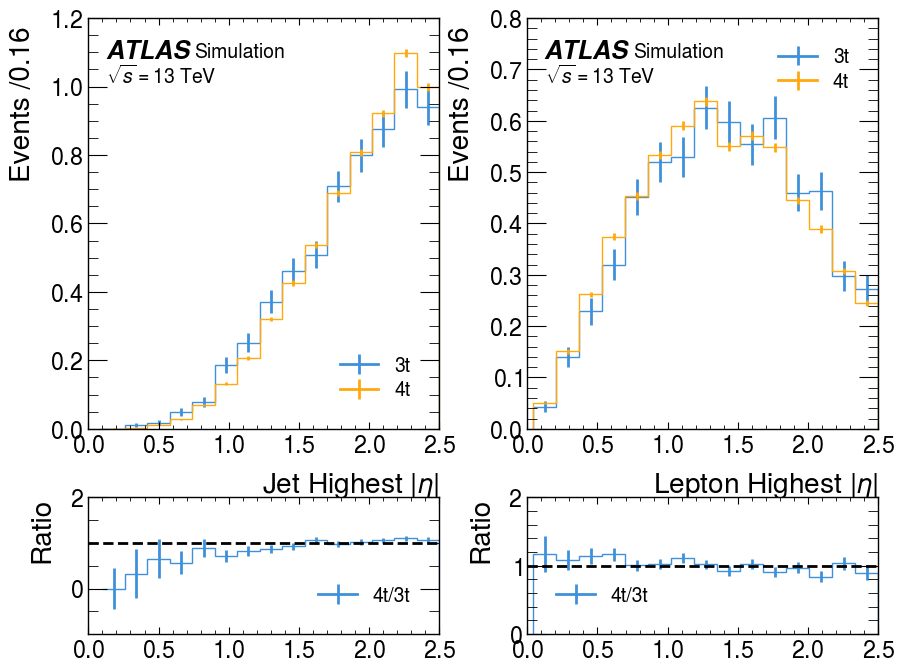

In [208]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_eta_jet_3t.eta), np.abs(highest_eta_jet_4t.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_eta_lepton_3t.eta), np.abs(highest_eta_lepton_4t.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Highest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

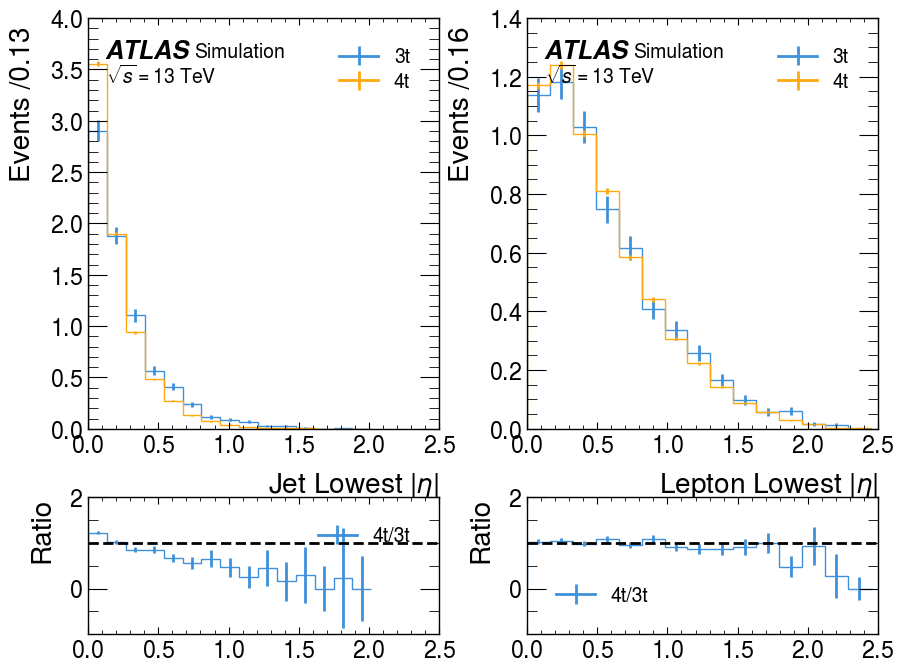

In [209]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_eta_jet_3t.eta), np.abs(lowest_eta_jet_4t.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_eta_lepton_3t.eta), np.abs(lowest_eta_lepton_4t.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Lowest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

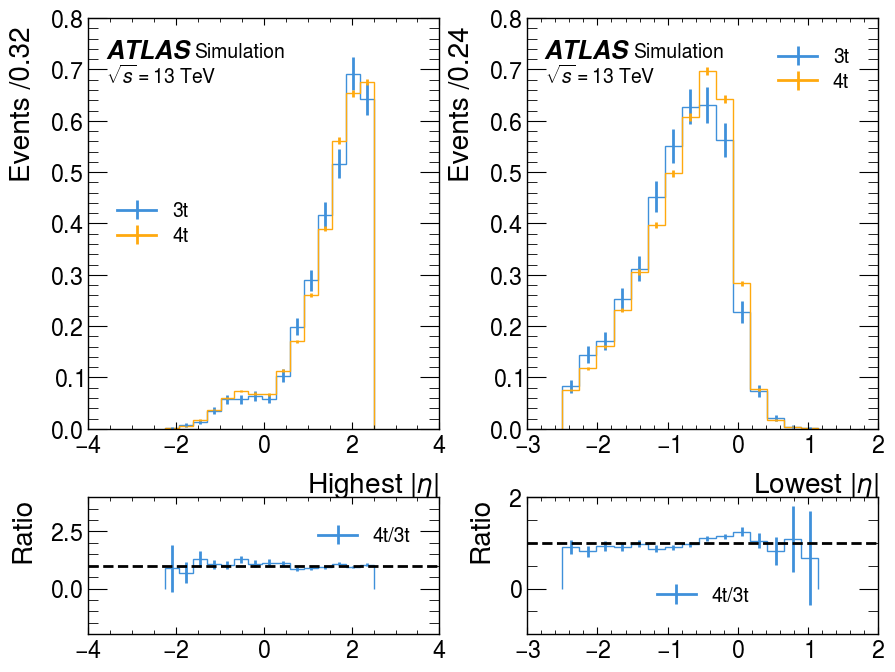

In [210]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_eta_3t.eta, highest_eta_4t.eta], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_eta_3t.eta, lowest_eta_4t.eta], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### 3. $\phi$

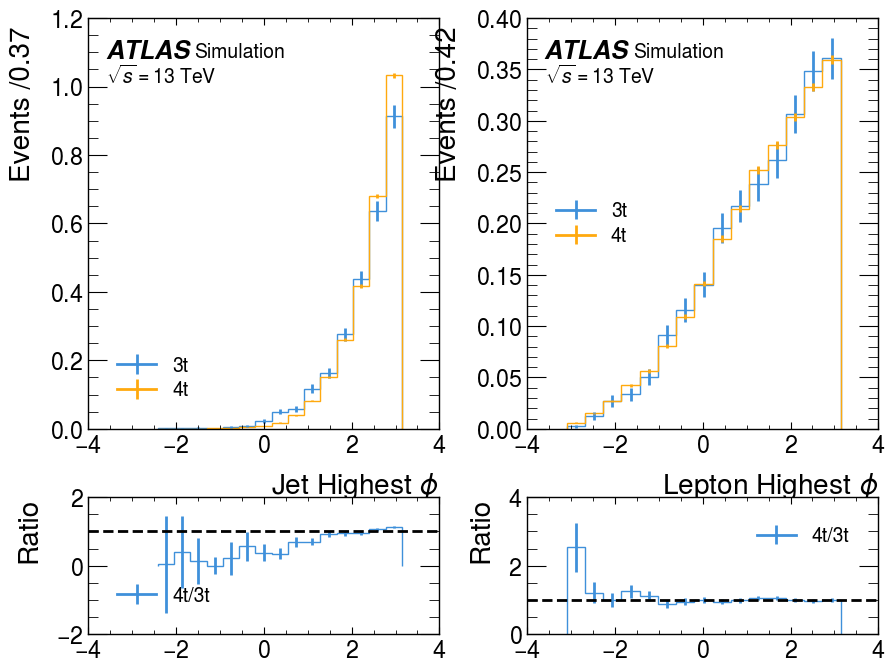

In [211]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_phi_jet_3t.phi, highest_phi_jet_4t.phi], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_phi_lepton_3t.phi, highest_phi_lepton_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Highest $\phi$')
ax[0,1].set_xlabel(r'Lepton Highest $\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

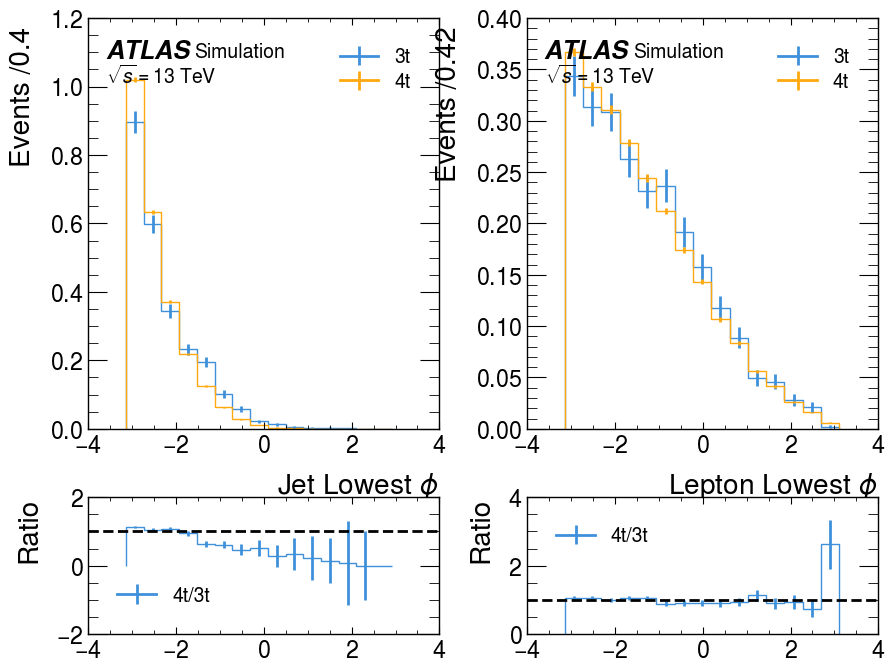

In [212]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_phi_jet_3t.phi, lowest_phi_jet_4t.phi], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_phi_lepton_3t.phi, lowest_phi_lepton_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Lowest $\phi $')
ax[0,1].set_xlabel(r'Lepton Lowest $\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

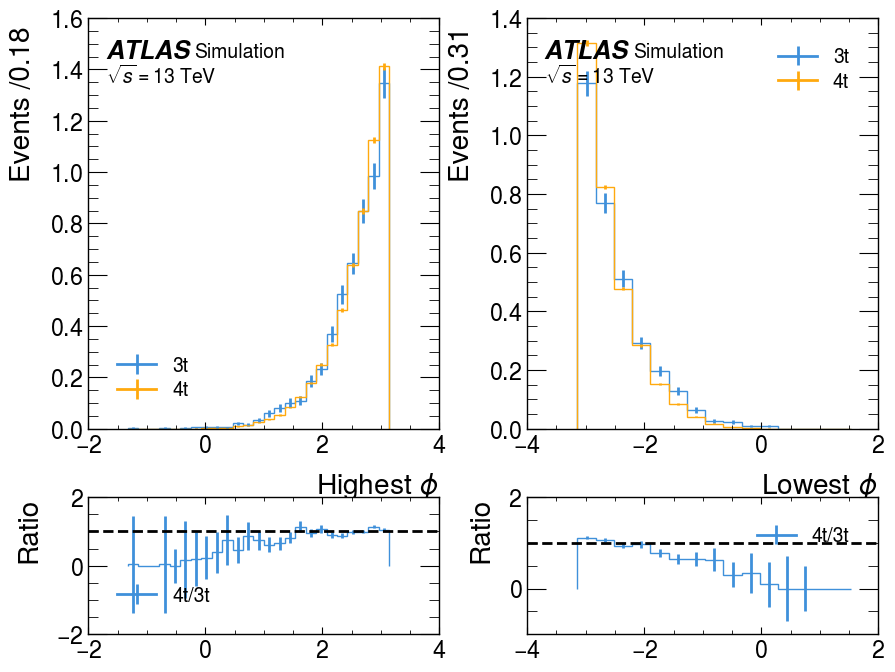

In [213]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_phi_3t.phi, highest_phi_4t.phi], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_phi_3t.phi, lowest_phi_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $\phi$')
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### 4. $\Delta R$

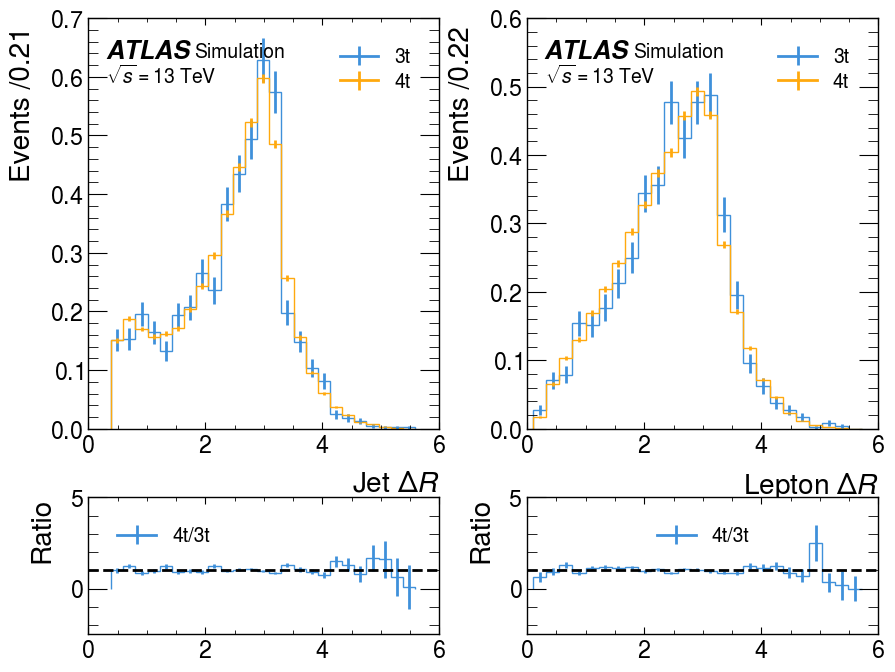

In [214]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t),highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_pt_lepton_3t.deltaR(second_highest_pt_lepton_3t),highest_pt_lepton_4t.deltaR(second_highest_pt_lepton_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\Delta R$')
ax[0,1].set_xlabel(r'Lepton $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

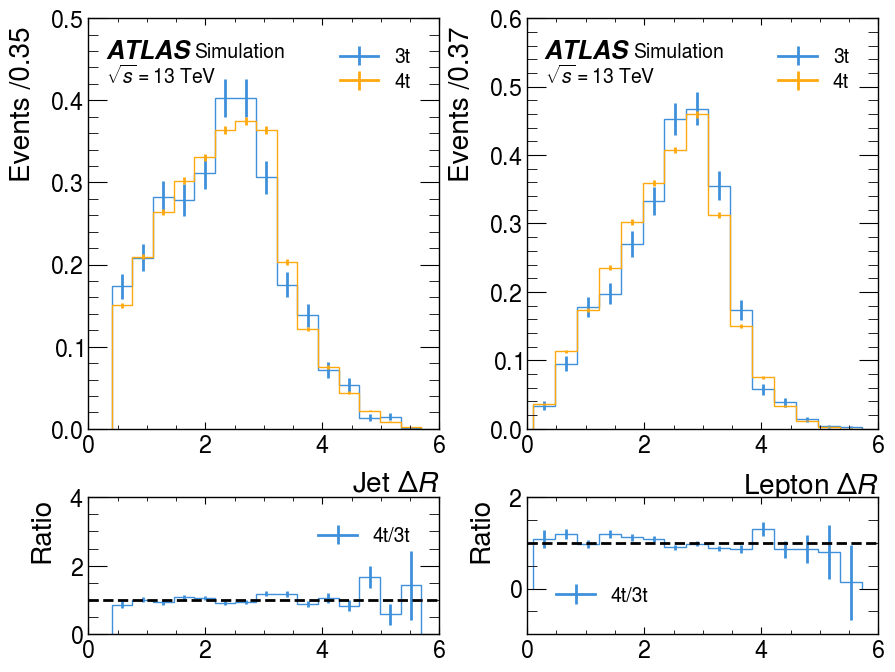

In [215]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_jet_3t.deltaR(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaR(second_lowest_pt_jet_4t)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_pt_lepton_3t.deltaR(second_lowest_pt_lepton_3t),lowest_pt_lepton_4t.deltaR(second_lowest_pt_lepton_4t)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\Delta R$')
ax[0,1].set_xlabel(r'Lepton $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

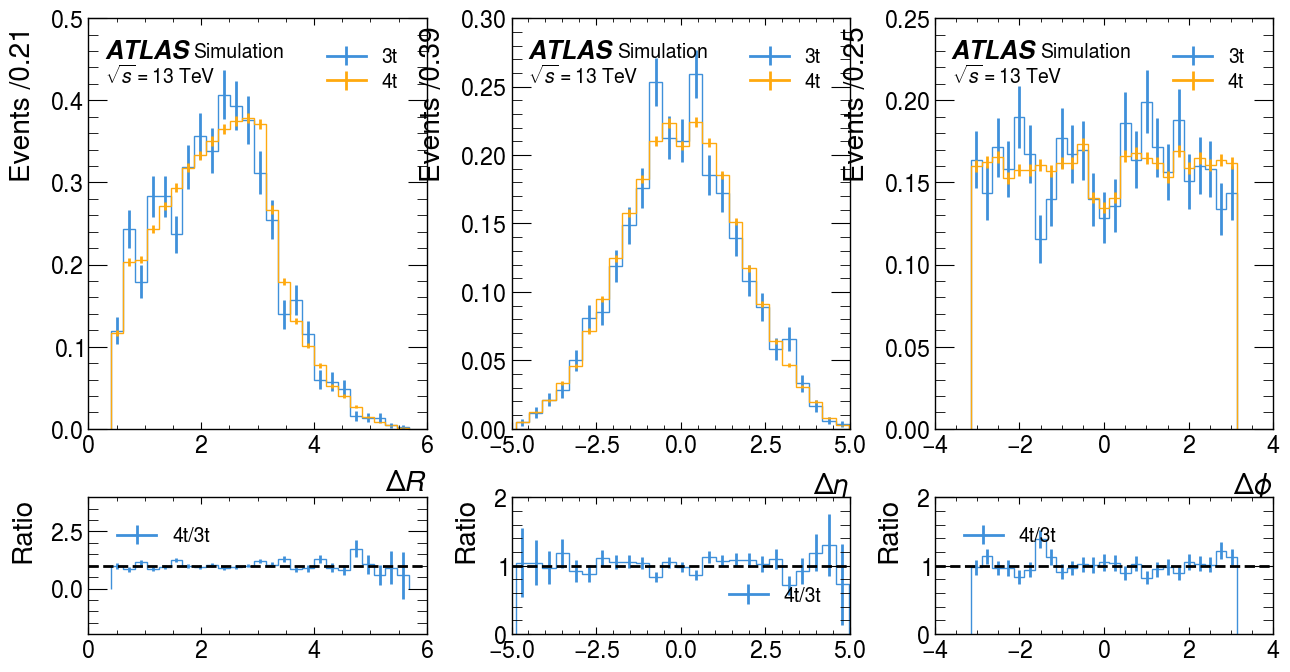

In [216]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([lowest_pt_jet_3t.deltaR(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaR(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_pt_jet_3t.deltaeta(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaeta(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([lowest_pt_jet_3t.deltaphi(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaphi(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

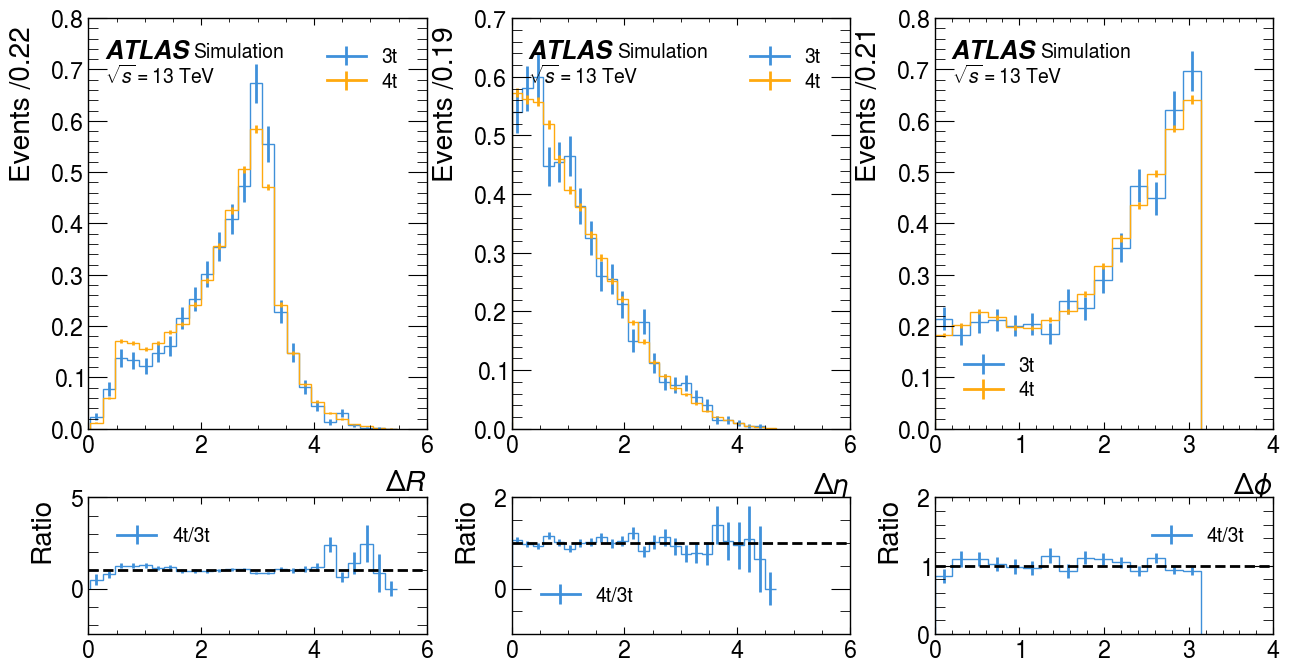

In [217]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_pt_3t, deltaR_highest_pt_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_pt_3t, deltaeta_highest_pt_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_pt_3t, deltaphi_highest_pt_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

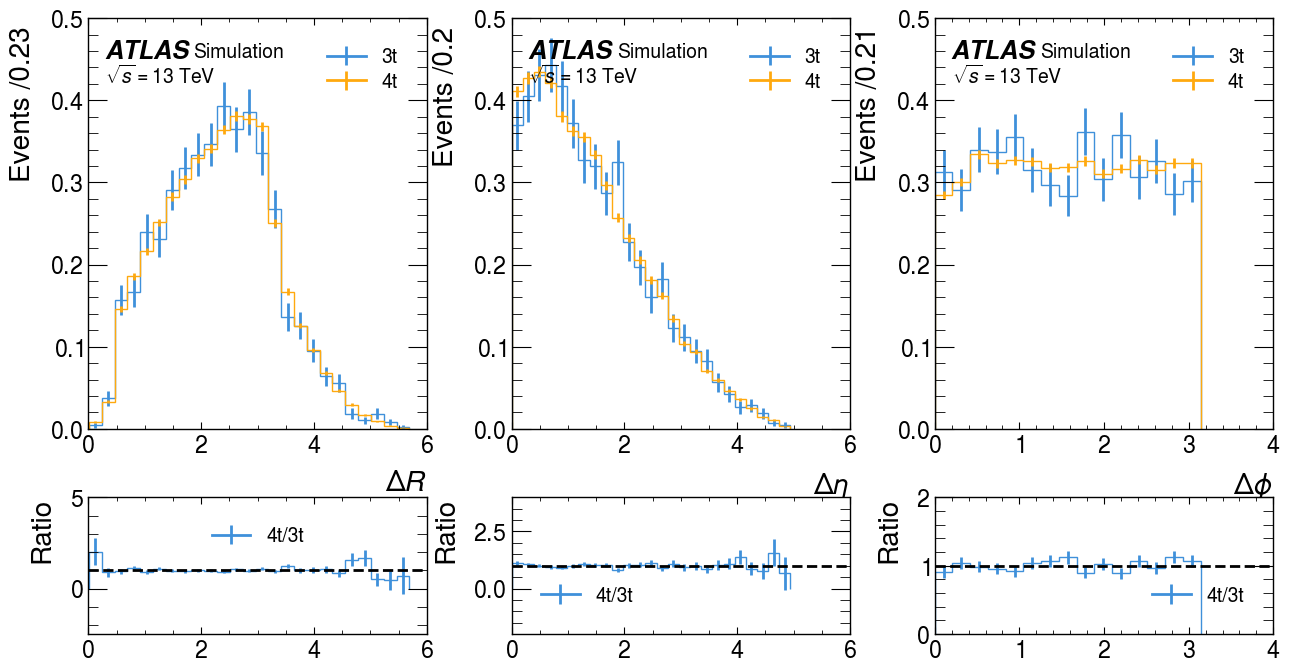

In [218]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_pt_3t, deltaR_lowest_pt_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_pt_3t, deltaeta_lowest_pt_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_pt_3t, deltaphi_lowest_pt_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

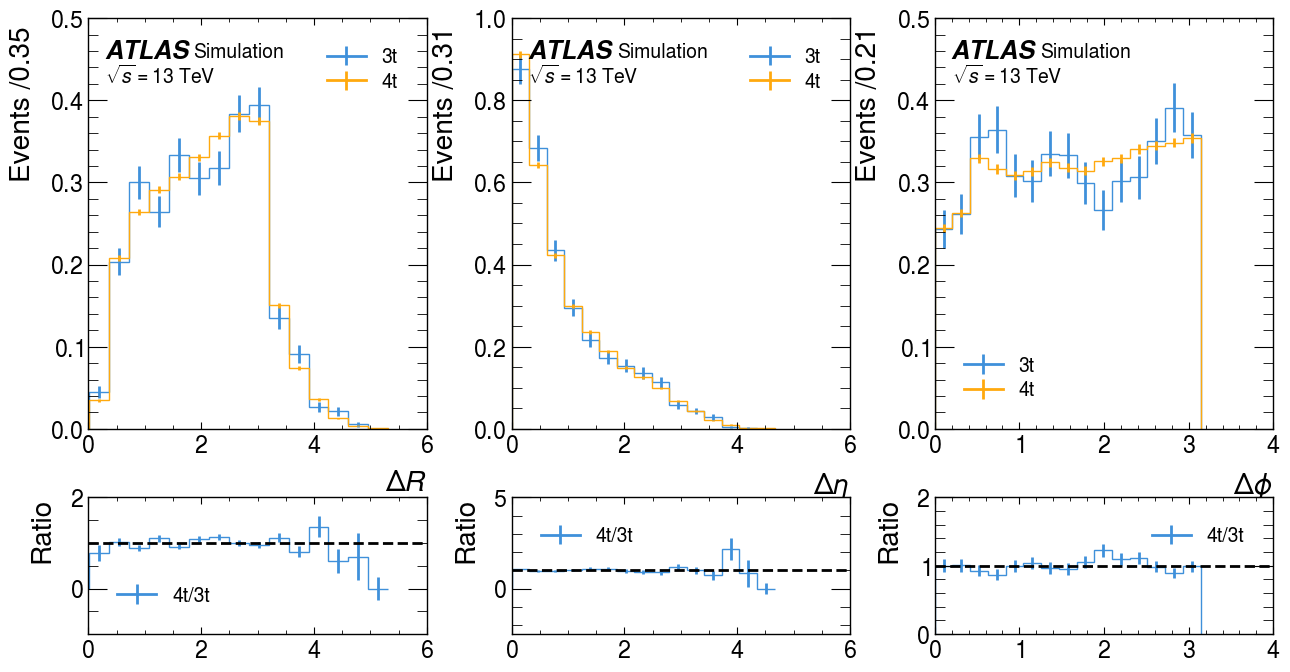

In [219]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_eta_3t, deltaR_highest_eta_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_eta_3t, deltaeta_highest_eta_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_eta_3t, deltaphi_highest_eta_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

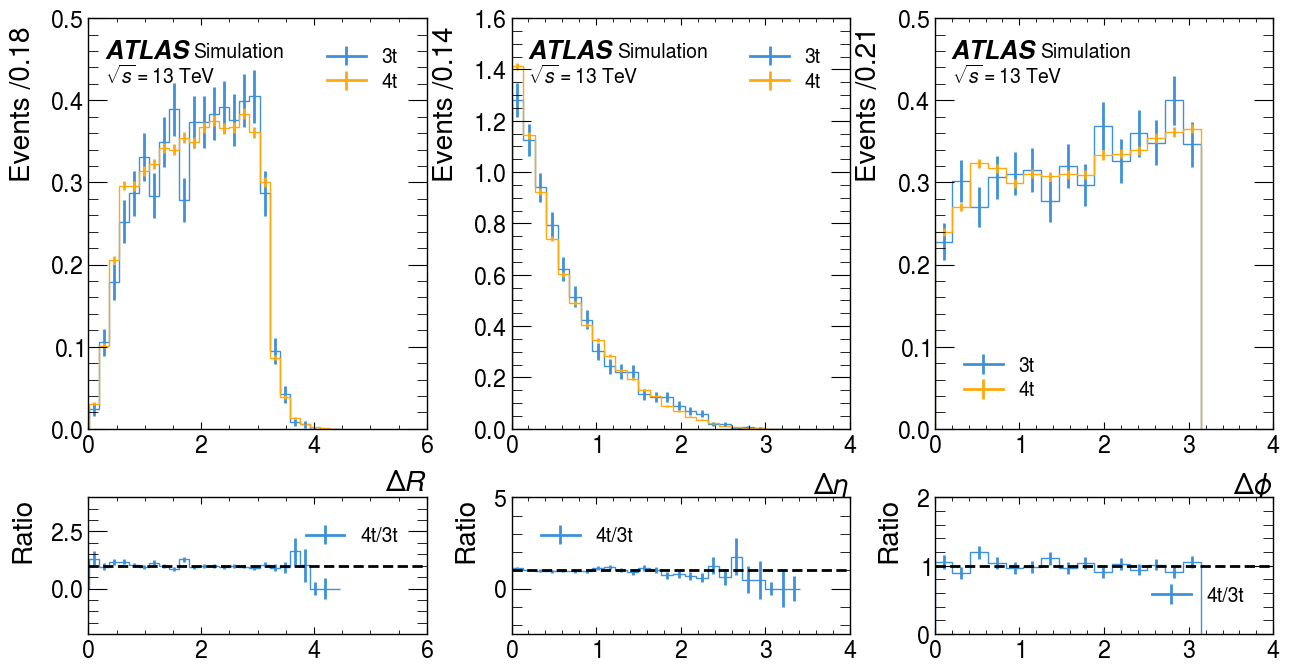

In [220]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_eta_3t, deltaR_lowest_eta_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_eta_3t, deltaeta_lowest_eta_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_eta_3t, deltaphi_lowest_eta_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

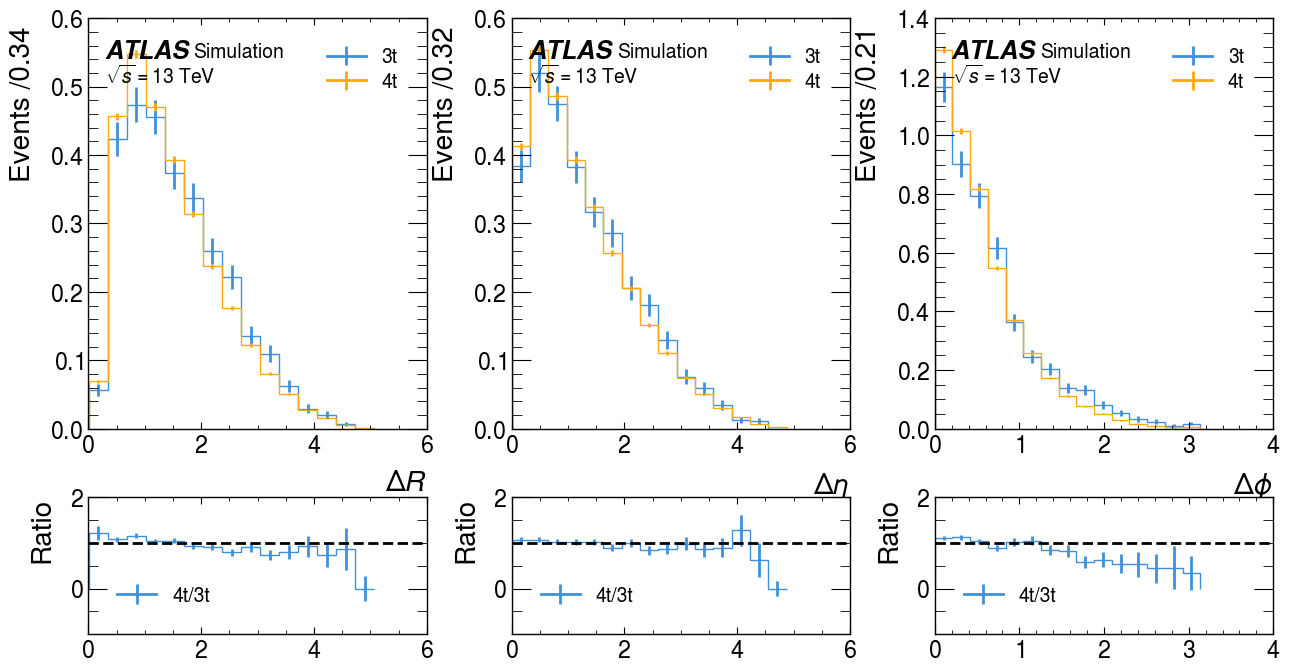

In [221]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_phi_3t, deltaR_highest_phi_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_phi_3t, deltaeta_highest_phi_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_phi_3t, deltaphi_highest_phi_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

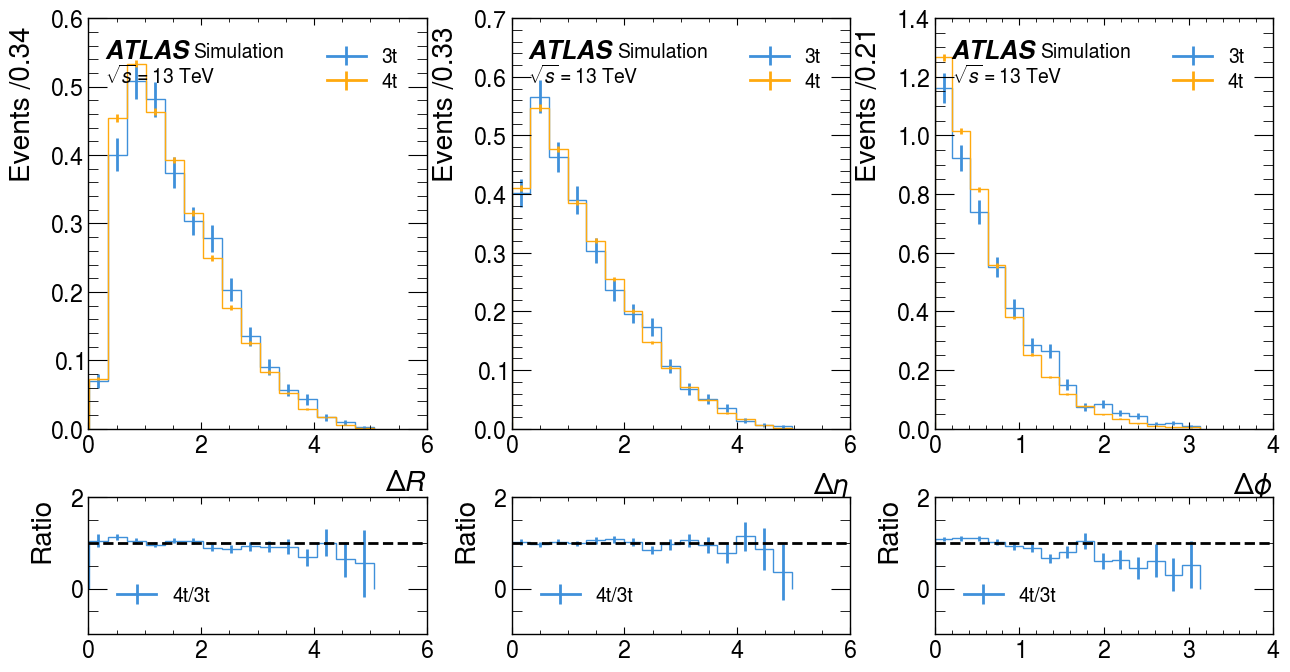

In [222]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_phi_3t, deltaR_lowest_phi_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_phi_3t, deltaeta_lowest_phi_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_phi_3t, deltaphi_lowest_phi_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

## Using individual Lepton Channels

### 1. Seperating into 2LSS and 3L

In [223]:
leptons_2LSS_4t = leptons_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]
jets_2LSS_4t = jets_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]

leptons_3L_4t = leptons_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]
jets_3L_4t = jets_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]

ratio_2LSS_4t = len(leptons_2LSS_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))
ratio_3L_4t = len(leptons_3L_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))

leptons_2LSS_3t = leptons_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]
jets_2LSS_3t = jets_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]

leptons_3L_3t = leptons_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]
jets_3L_3t = jets_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]

ratio_2LSS_3t = len(leptons_2LSS_3t)/(len(leptons_2LSS_3t) + len(leptons_3L_3t))
ratio_3L_3t = len(leptons_3L_3t)/(len(leptons_2LSS_3t) + len(leptons_3L_3t))

### 2. Sorting

In [224]:
highest_2LSS_pt_jet_4t = jets_2LSS_4t[:,0]
highest_2LSS_pt_lepton_4t = leptons_2LSS_4t[:,0]
highest_2LSS_pt_4t = np.maximum(highest_2LSS_pt_jet_4t.pt, highest_2LSS_pt_lepton_4t.pt)

highest_3L_pt_jet_4t = jets_3L_4t[:,0]
highest_3L_pt_lepton_4t = leptons_3L_4t[:,0]
highest_3L_pt_4t = np.maximum(highest_3L_pt_jet_4t.pt, highest_3L_pt_lepton_4t.pt)

lowest_2LSS_pt_jet_4t = jets_2LSS_4t[:,-1]
lowest_2LSS_pt_lepton_4t = leptons_2LSS_4t[:,-1]
lowest_2LSS_pt_4t = np.minimum(lowest_2LSS_pt_jet_4t.pt, lowest_2LSS_pt_lepton_4t.pt)

lowest_3L_pt_jet_4t = jets_3L_4t[:,-1]
lowest_3L_pt_lepton_4t = leptons_3L_4t[:,-1]
lowest_3L_pt_4t = np.minimum(lowest_3L_pt_jet_4t.pt, lowest_3L_pt_lepton_4t.pt)

second_highest_2LSS_pt_jet_4t = jets_2LSS_4t[:,1]
second_highest_3L_pt_jet_4t = jets_3L_4t[:,1]
middle_3L_pt_lepton_4t = leptons_3L_4t[:,1]

highest_2LSS_pt_jet_3t = jets_2LSS_3t[:,0]
highest_2LSS_pt_lepton_3t = leptons_2LSS_3t[:,0]
highest_2LSS_pt_3t = np.maximum(highest_2LSS_pt_jet_3t.pt, highest_2LSS_pt_lepton_3t.pt)

highest_3L_pt_jet_3t = jets_3L_3t[:,0]
highest_3L_pt_lepton_3t = leptons_3L_3t[:,0]
highest_3L_pt_3t = np.maximum(highest_3L_pt_jet_3t.pt, highest_3L_pt_lepton_3t.pt)

lowest_2LSS_pt_jet_3t = jets_2LSS_3t[:,-1]
lowest_2LSS_pt_lepton_3t = leptons_2LSS_3t[:,-1]
lowest_2LSS_pt_3t = np.minimum(lowest_2LSS_pt_jet_3t.pt, lowest_2LSS_pt_lepton_3t.pt)

lowest_3L_pt_jet_3t = jets_3L_3t[:,-1]
lowest_3L_pt_lepton_3t = leptons_3L_3t[:,-1]
lowest_3L_pt_3t = np.minimum(lowest_3L_pt_jet_3t.pt, lowest_3L_pt_lepton_3t.pt)

second_highest_2LSS_pt_jet_3t = jets_2LSS_3t[:,1]
second_highest_3L_pt_jet_3t = jets_3L_3t[:,1]
middle_3L_pt_lepton_3t = leptons_3L_3t[:,1]

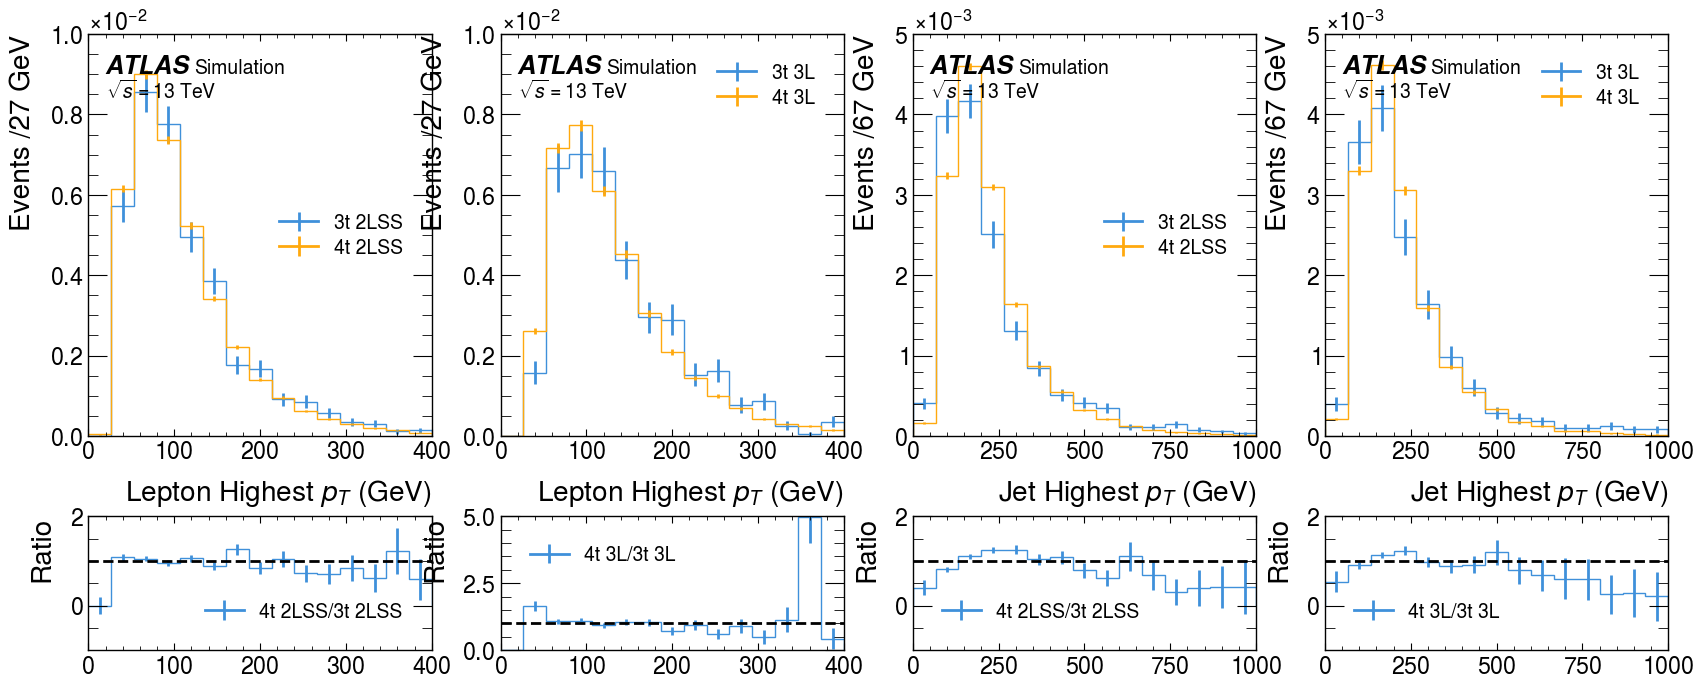

In [225]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_2LSS_pt_lepton_3t.pt/1000, highest_2LSS_pt_lepton_4t.pt/1000], 15, ['3t 2LSS','4t 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
histogram([highest_3L_pt_lepton_3t.pt/1000, highest_3L_pt_lepton_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E3))
histogram([highest_2LSS_pt_jet_3t.pt/1000, highest_2LSS_pt_jet_4t.pt/1000], 15, ['3t 2LSS', '4t 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E3))
histogram([highest_3L_pt_jet_3t.pt/1000, highest_3L_pt_jet_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E3))
ax[0,0].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Highest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Highest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

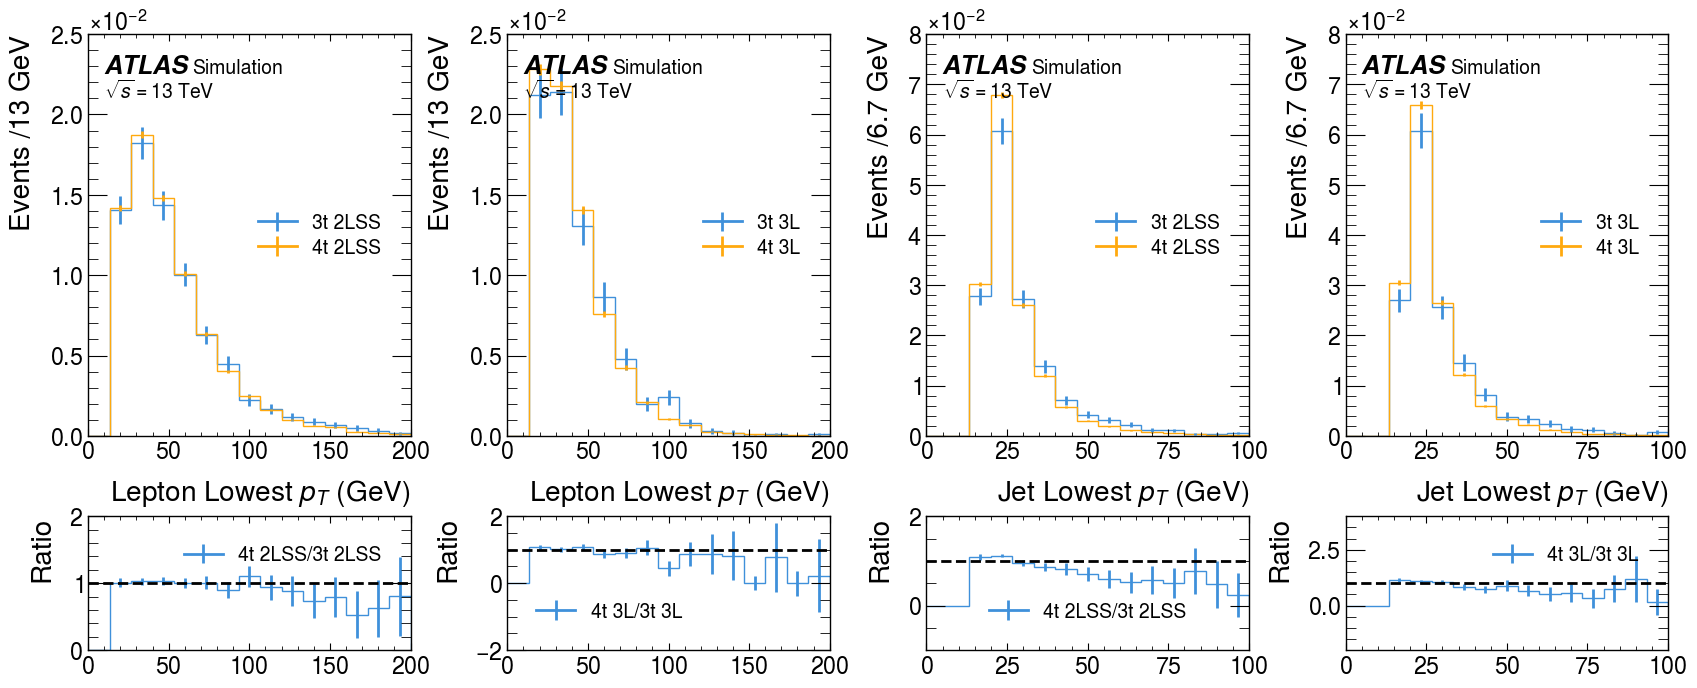

In [226]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_2LSS_pt_lepton_3t.pt/1000, lowest_2LSS_pt_lepton_4t.pt/1000], 15, ['3t 2LSS','4t 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,2E2))
histogram([lowest_3L_pt_lepton_3t.pt/1000, lowest_3L_pt_lepton_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,2E2))
histogram([lowest_2LSS_pt_jet_3t.pt/1000, lowest_2LSS_pt_jet_4t.pt/1000], 15, ['3t 2LSS', '4t 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E2))
histogram([lowest_3L_pt_jet_3t.pt/1000, lowest_3L_pt_jet_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()